# Определение стоимости автомобилей

## Описание проекта

Сервису по продаже автомобилей с пробегом «Не бит, не крашен» для внедрения в новое приложение требуется механизм(модель), позволяющий рассчитать примерную рыночную стоимость автомобиля по его основным характеристикам. 

###  Цель проекта
Создать модель, которая на основании имеющихся данных о продающихся(проданных) автомобилях и характеристиках автомобиля пользователя предсказывает(расчитывает) рыночную стоимость автомобиля пользователя. Показателем качества модели принять RMSE, которая должна быть не выше 2500. 
 

###  Задачи проекта
- Подготовить данные
- Построить одну модель из семейства градиентного бустинга (LightGBM) 
- Построить несколько моделей, не использующих градиентный бустинг 
- Подобрать наиболее оптимальные гиперпараметры для каждой модели
- Проверить модели на тестовой выборке.
- Выбрать лучшую модель с учетом критериев, заданных заказчиком:
    - скорость обучения;
    - скорость предсказания;
    - точность предсказания.

###  Этапы проекта:
- Исследование данных:
    - загрузка данных
    - изучение данных (что означают столбцы, к каким хар-ам авто относятся)
    - оценка данных (типы переменных, типы категорий (номинативная, количественная))
- Предъобработка данных:
    - проверка и переименование названий столбцов
    - обработка дат
    - проверка и заполнение пропусков
    - проверка на дубликаты (полные, неполные)
    - проверка на мультиколлинеарность (выявление коррелированных столбцов, выборочное исключение при необходимости)
    - выявление и исключение аномальных значений (выводы внести в ТЗ приложения)
    - стратификация по близким признакам (при необходимости)
- Исследование данных на предмет применимости для машинного обучения
    - изучение признаков и целевой переменной
    - изучение распределений для количественных переменных (оценка формы, близость к нормальному)
    - изучение возможных взаимосвязей между независимыми и зависимой переменной
    - выбор функции связи и преобразование целевой переменной (при необходимости) 
    - кодирование номинативных переменных (с присвоением рангов, методом однопроходного кодирования)
    - масштабирование количественных переменных
- Машинное обучение с учителем
    - подготовка функции, реализующей выбор лучших гиперпараметров с использованием метода GridSearch и кроссвалидации, минимизирующей риски переобучения моделей
    - разделение обработанного ДФ на обучающую и тестовую повыборки 
    - расчет базовых (без выбора гиперпараметров) показателей моделей (линейной регрессии с регуляризацией, градиентного бустинга, дерева решений, обобщенной аддитивной модели на основе сплайнов)
    - подбор гиперпараметров с помощью метода кроссвалидации
    - проверка моделей на тестовой выборке
    - выбор лучщей модели с учетом критериев заказчика
    

###  Описание данных
- Файлы данных
    - /datasets/autos.csv

- Целевые признаки
    - цена
    
- Независимые признаки:
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - Repaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Установка необходимых библиотек

In [4]:
!pip install lightgbm
!pip install pygam
!statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: statsmodels: command not found


## Импорт библиотек

In [88]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm 
import statsmodels.formula.api as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from pygam import GAM, s, f, LogisticGAM
import time


import scipy.stats as stats
import statsmodels.api as sm



## Задание констант

In [6]:
RS = 123456

## Определение функций

In [7]:
def search_best_params(features, target, model, params, random_state):
    #Формируем модель разбиения на подвыборки
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state = random_state)
    
    #Формируем модель перебора гиперпараметров 
    G_models = GridSearchCV(model, params)
    print("START fiting")
    start = time.time()
    G_models.fit(features, target)
    end = time.time()
    fit_time = (end - start)
    print(f"Inital fiting finished. Fit time: {fit_time} s")
    
    #Проводим кроссвалидацию
    print("START cross validation")
    start = time.time()
    n_scores = cross_val_score\
    (G_models, features, target, scoring= 'neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=10)
    end = time.time()
    grid_time = (end - start)
    
    print(f"Grid searching finished. \
    Grid time: {grid_time} s,\
    Mean fit time: {np.mean(G_models.cv_results_.get('mean_fit_time'))} s\
    Mean predict time: {np.mean(G_models.cv_results_.get('mean_score_time'))} s")
    times = (grid_time, np.mean(G_models.cv_results_.get('mean_fit_time')), np.mean(G_models.cv_results_.get('mean_score_time')))

    #Выводим статистики для метрики
    print(f'mean RMSE: {(np.mean(abs(n_scores)))**0.5}, std RMSE: {(np.std(abs(n_scores)))**0.5}') 
      
    #Выводим лучшие гиперпараметры
    try:
        print(f'best params: {G_models.best_params_}')
    except:
        print(f'проблемы с поиском лучшей модели')
     
    return (G_models, times, (np.mean(abs(n_scores)))**0.5)    

In [8]:
def write_results(all_results, dict_with_new_result):
    all_results['step'].append(dict_with_new_result.get('step'))
    all_results['model_name'].append(dict_with_new_result.get('model_name'))
    all_results['RMSE'].append(dict_with_new_result.get('RMSE'))
    all_results['fit_time'].append(dict_with_new_result.get('fit_time'))
    all_results['predict_time'].append(dict_with_new_result.get('predict_time'))
    all_results['feature_importances'].append(dict_with_new_result.get('feature_importances'))
    return all_results

## Загрузка данных

In [9]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/autos.csv")

## Обзор данных

In [10]:
#Срез данных
display(df.head())

#Структура датафрейма
display(df.info())

#Фиксируем размер начального ДФ
inital_len = df.shape[0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

## Базовая предобработка

### Привидение названий столбцов к принятому стилю

In [11]:
#Новые названия
new_cols = ["date_crawled", "price", "vehicle_type", "reg_year", "gearbox",
            "power", "model", "km", "reg_month", "fuel_type", "brand",
           "repaired", "date_created", "numb_of_pic", "postal_code", "last_seen"]
#Словарь соответвия
col_dict = {df.columns[index]: new_cols[index] for index in range(len(new_cols))}

#Проверка корректности соответсвий
print(col_dict)

{'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'reg_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Kilometer': 'km', 'RegistrationMonth': 'reg_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'Repaired': 'repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'numb_of_pic', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'}


In [12]:
#Смена названий
df.rename(columns = col_dict, inplace = True)

### Уточнение типов данных

In [13]:
#Замена типов данных для полей с датами
df.date_crawled = pd.to_datetime(df.date_crawled)
df.date_created = pd.to_datetime(df.date_created)
df.last_seen = pd.to_datetime(df.last_seen)

## Проверка на наличие пропусков в данных

In [14]:
df.isna().sum()

date_crawled        0
price               0
vehicle_type    37490
reg_year            0
gearbox         19833
power               0
model           19705
km                  0
reg_month           0
fuel_type       32895
brand               0
repaired        71154
date_created        0
numb_of_pic         0
postal_code         0
last_seen           0
dtype: int64

В ДФ присутсвуют пропуски в следующих столбцах:
 - vehicle_type (тип двигателя),
 - gearbox (тип коробки передач),
 - model (модель),
 - repaired (был ли ремонт).
 
 Все это номинативные переменные. Принимая во внимание условия нашей задачи, можно предположить, что цена автомобиля, за которую он был приобретен зависит от наличия/отсутсвия этих данных. То есть, к примеру, факт отсутсвия сведений о том, была ли машина в ремонте предположительно может оказывать статистически значимое влияние на решение потенциального покупателя рассматривать данное предложение и в дальнейшем осуществить покупку. Поэтому считаю правильным во всех перечисленных столбцах заменить пропущенные  значения на заглушку "unknown"

In [15]:
df.fillna("unknown", inplace = True)

### Проверка на адекватность данных

#### Проверка на наличие полных дубликатов

In [16]:
df[df.duplicated()]

,date_crawled,price,vehicle_type,reg_year,gearbox,power,model,km,reg_month,fuel_type,brand,repaired,date_created,numb_of_pic,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Удалим имеющиеся полные дубликаты

In [17]:
df = df.drop_duplicates()

#### Проверка на корректность значений из столбцов дат

Требования, которые обязательно стоит проверить:
- цена должна быть положительной;
- мощность должна быть в диапазоне от 4 (https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html) до 5000 лс (https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire#Devel_Sixteen_5000);
- пробег должен быть положительным.

In [18]:
#Подсчет количества уникальных значений
df.nunique()

date_crawled    271174
price             3731
vehicle_type         9
reg_year           151
gearbox              3
power              712
model              251
km                  13
reg_month           13
fuel_type            8
brand               40
repaired             3
date_created       109
numb_of_pic          1
postal_code       8143
last_seen       179150
dtype: int64

Среди всех значений серьезные подозрения вызывает столбец reg_year, у которого 151 уникальное значение. С учетом того, что в указанном столбце должны храниться данные о годе регистрации, ожидаемо количество значений должно быть значительно меньше. Разумный срок старта продаж - с 1950-х, а значит число уникальных значений не должно быть больше 73-х. Посмотрим, какие конкретно данные заложены в рассматриваемый столбец. 

#### Год регистрации

In [19]:
df.reg_year.sort_values(ascending = False).unique()

array([9999, 9996, 9450, 9229, 9000, 8888, 8500, 8455, 8200, 8000, 7800,
       7500, 7100, 7000, 6500, 6000, 5911, 5900, 5600, 5555, 5300, 5000,
       4800, 4500, 4100, 4000, 3800, 3700, 3500, 3200, 3000, 2900, 2800,
       2500, 2290, 2222, 2200, 2066, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992,
       1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981,
       1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970,
       1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959,
       1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948,
       1947, 1946, 1945, 1944, 1943, 1942, 1941, 1940, 1938, 1937, 1936,
       1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1925, 1923,
       1920, 1919, 1915, 1910, 1800, 1688, 1602, 1600, 1500, 1400, 1300,
       1255, 1253, 1234, 1200, 1111, 1039, 1001, 10

Очевидно, в данных присутсвуют ошибочные значения. Удалим из ДФ строчки, их содержащие.

In [20]:
df = df.query('reg_year > 1950 and reg_year < 2019')

Посмотрим, в какие годы было максимальное количество зарегистрированных автомобилей.

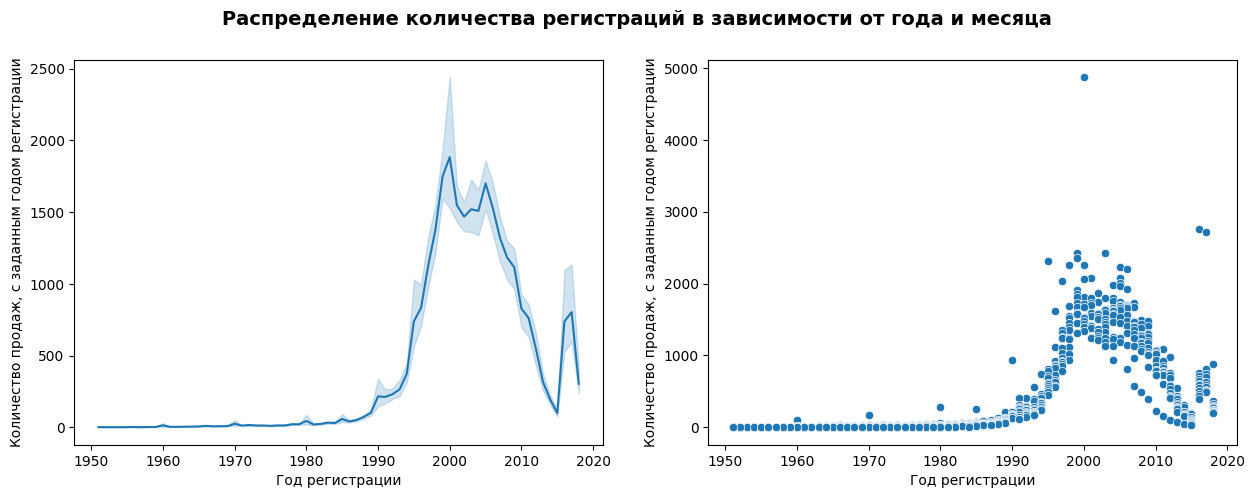

In [21]:
group_by_reg = df.groupby(by = ['reg_year', 'reg_month'], as_index = [False, False])\
.agg({'date_crawled': 'count'})\
.rename(columns = {'date_crawled':'sells'})\
.sort_values(by = 'sells', ascending = False)

#Графики распределений
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение количества регистраций в зависимости от года и месяца', fontsize=14, fontweight='bold');

line_plot = sns.lineplot(data = group_by_reg, x = "reg_year", y = "sells", ax = axes[0]);
line_plot.set_xlabel("Год регистрации")
line_plot.set_ylabel("Количество продаж, с заданным годом регистрации")

scat_plot = sns.scatterplot(data = group_by_reg, x = "reg_year", y = "sells");
scat_plot.set_xlabel("Год регистрации")
scat_plot.set_ylabel("Количество продаж, с заданным годом регистрации");

Очевидно, что автомобили, загегистрированные до 1980 года очень слабо представлены в ДФ. Это объясними, так как массовое производство автомобилей началось после 1980 - 1990 годов. Автомобили же зарегистрированные до 1980 годов, это редкие автомобили,  координально отличающиеся от массового автопрома. Наличие такой непредставительной группы внутри ДФ может снизить качество предсказаний моделей. Поэтому целесообразно их удалить или выделить в отденый ДФ.

In [22]:
#Подсчет количества "раритетных" автомобилей
df.groupby(by = 'reg_year', as_index = False)\
.agg(sells = ('date_crawled', 'count')).query('reg_year < 1980').sells.sum()

3188

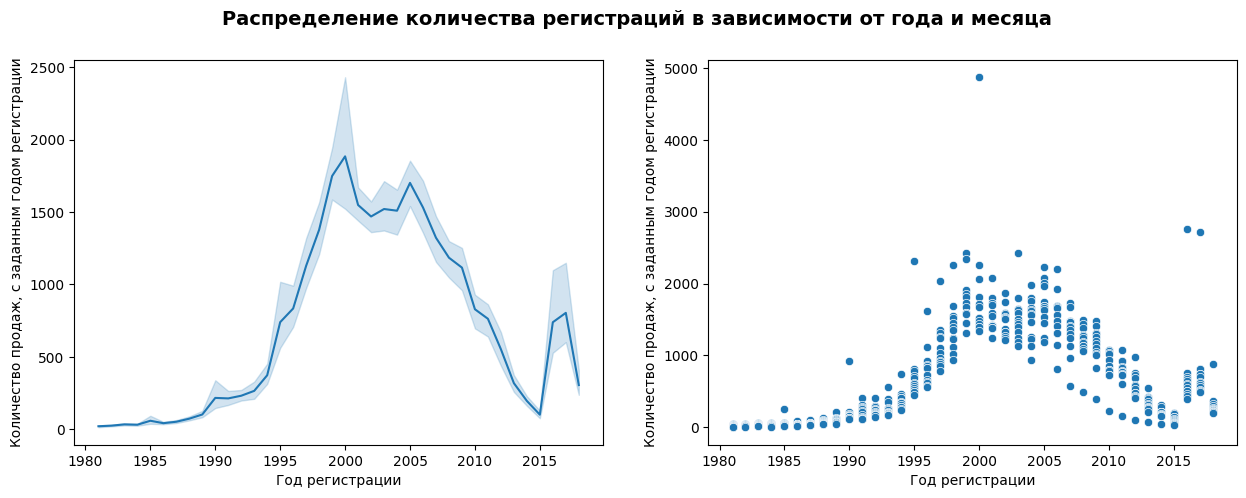

In [23]:
#Удаление "раритетных авто"
df = df.query('reg_year > 1980')
group_by_reg = group_by_reg.query('reg_year > 1980')

#Графики распределений
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение количества регистраций в зависимости от года и месяца', fontsize=14, fontweight='bold');

line_plot = sns.lineplot(data = group_by_reg, x = "reg_year", y = "sells", ax = axes[0]);
line_plot.set_xlabel("Год регистрации")
line_plot.set_ylabel("Количество продаж, с заданным годом регистрации")

scat_plot = sns.scatterplot(data = group_by_reg, x = "reg_year", y = "sells");
scat_plot.set_xlabel("Год регистрации")
scat_plot.set_ylabel("Количество продаж, с заданным годом регистрации");

По графикам видно, что есть несколько годов, в которых есть значимые всплески по количеству продаж, приходящихся на какой-то отдельный месяц. Но в целом, продажи по месяцам распределены относительно равномерно. 

Оценим, влияет ли месяц регистрации на стоимость автомобиля. Для этого рассмотрим 2000 - 2010 годы, в которые было зарегистрировано максимальное количество автомобилей. Внутри этих годом сгруппируемся по месяцам, посчитаем медиану и сравним медианы цен

In [24]:
#Расчет медианы по группировкам (год, месяц)
group_by_reg.query('reg_year > 1999 and reg_year < 2011').sort_values(by = ['reg_year', 'reg_month'])

price_by_reg = df\
.query('reg_year > 1999 and reg_year < 2011')\
.groupby(by = ['reg_year', 'reg_month'], as_index = [False, False])\
.agg({'price': 'median'})\
.rename(columns = {'price':'median_price'})\
.sort_values(by = 'median_price', ascending = False)\
.groupby(by = 'reg_year', as_index = False)\
.head(10)

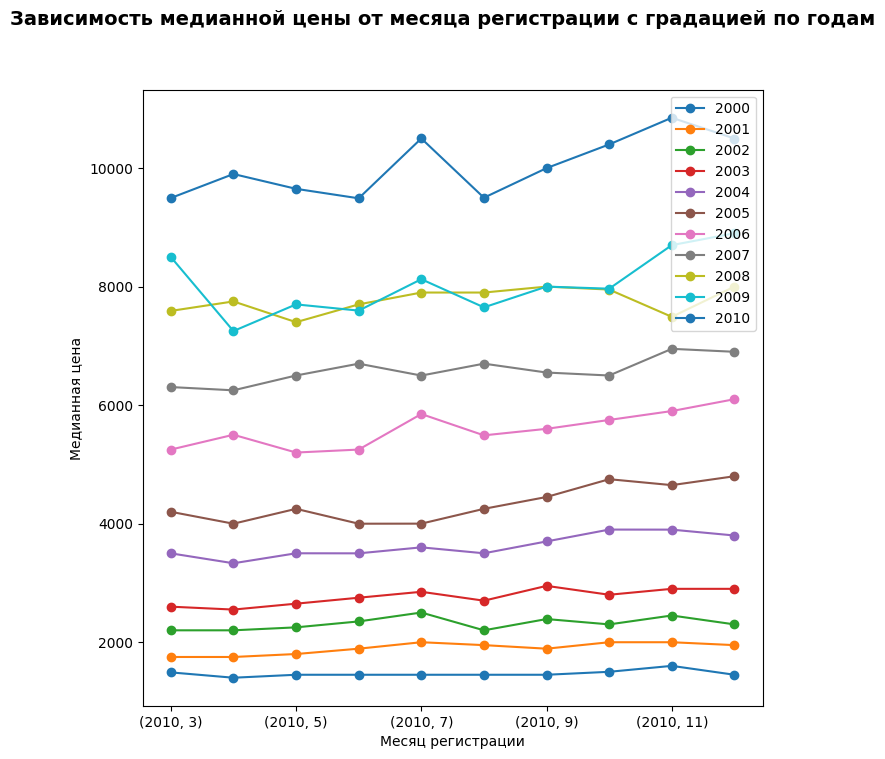

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

for year in range(2000, 2011):
    price_by_reg.query('reg_year == @year')\
    .sort_values(by = 'reg_month')\
    .plot(figsize = (8,8), style = '-o', ax = axes, label = f'{year}');
    plt.legend(['2000','2001','2002','2003','2004','2005','2006', '2007', '2008', '2009', '2010'])

fig.suptitle\
('Зависимость медианной цены от месяца регистрации с градацией по годам', \
 fontsize=14, fontweight='bold');

axes.set_xlabel("Месяц регистрации");
axes.set_ylabel("Медианная цена");

В целом,мы можем предположить, что цена продажи не зависит от месяца регистрации автомобиля. Посмотрим, как она зависит от года регистрации.

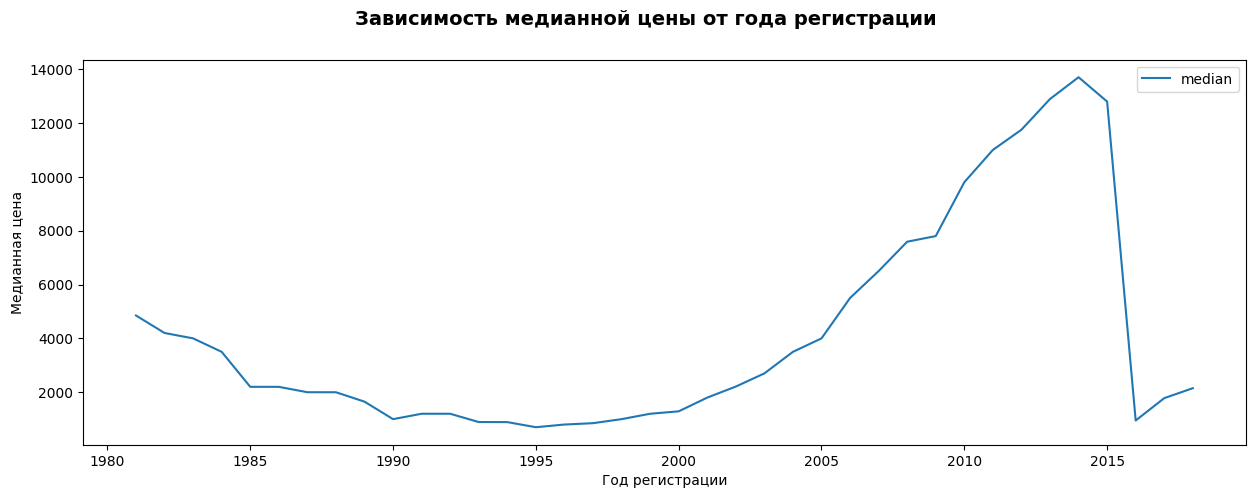

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df.groupby(by = 'reg_year', as_index = False)\
.agg(median = ('price','median'))\
.sort_values(by = 'reg_year', ascending = False)\
.plot(x= 'reg_year', y = 'median', ax = axes);

fig.suptitle('Зависимость медианной цены от года регистрации', fontsize=14, fontweight='bold');
axes.set_xlabel("Год регистрации");
axes.set_ylabel("Медианная цена"); 

По графику видно, что цена продаж для записей, зарегистрированных с 1980 по 1996, плавно падает, а для записей с 1996 по 2015 показывает стабильный уверенный рост. При этом для записей, зарегистрированных с  2016 года, цена резко падает вниз. То есть обрезается. Это связано с тем, что выгрузка из БД произведена в 2016 году и данных о продажах машин, зарегистрированных в 2016 в ДФ фактически нет. Для снижения рисков искажения предсказания, исключим из ДФ записи о машинах, зарегистрированных в 2016 году.     

In [27]:
df = df.query('reg_year < 2016')

#### Дата создания объявления

In [28]:
df.date_created.dt.year.sort_values(ascending = False).unique()

array([2016, 2015, 2014])

В ДФ все записи имеют дату создания, представленную тремя годами: 2014 -2016. Посмотрим, как распределено число объявлений по годам. 

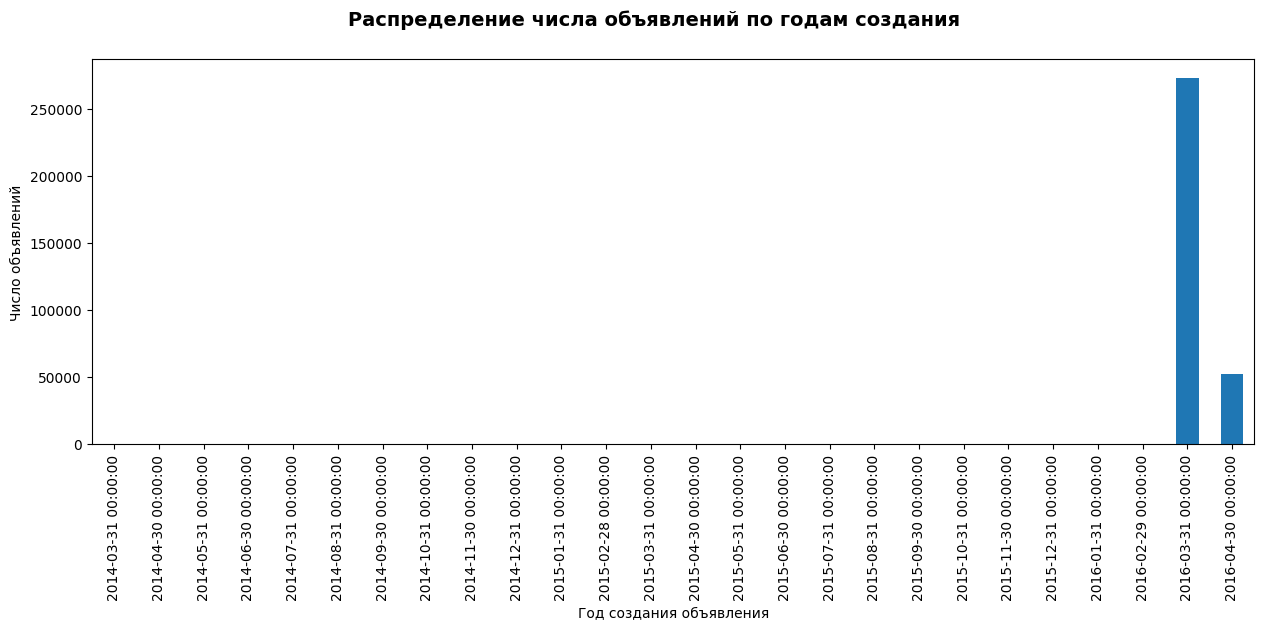

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df_sels_by_years = copy.deepcopy(df)
df_sels_by_years.index = df_sels_by_years.date_created
df_sels_by_years.resample('M').price.count().plot(kind = 'bar', ax = axes);

fig.suptitle('Распределение числа объявлений по годам создания', fontsize=14, fontweight='bold');
axes.set_xlabel("Год создания объявления");
axes.set_ylabel("Число объявлений"); 

Очевидно, что основная масса объявлений приходиться на февраль - апрель 2016 года. Период 2014-2015 гг. практически не представлен. Имеющиеся в нем объявления скорее всего тестовые и были созданы, например, чтобы протестировать сервис. Для оптимизации работы предиктивных моделей исключим записи из периода с 2014 по 2015 год из основного ДФ. 

Также заметно, что по какой-то причине подавляющее большинство количество объявлений создано в марте. Еще немного - в апреле. Посмотрим как расределены медианы цен на автомобили в зависимости от дня создания объявления в этих месяцах.

In [30]:
#Удаление непредставительных периодов
df = df.query('date_created.dt.year > 2015')

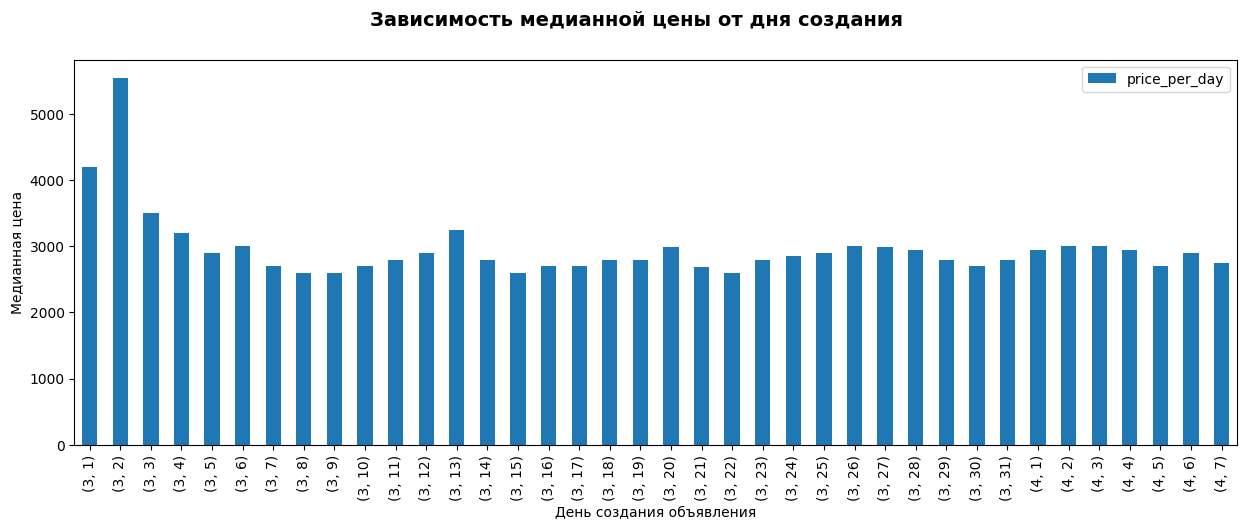

In [31]:
#Зависимость цены от дня марте-апреле
df['day_created'] = df.date_created.dt.day
df['month_created'] = df.date_created.dt.month

df_by_created = df\
.query('month_created == 3 or month_created == 4')\
.groupby(by = ['month_created','day_created'], as_index = [False, False])\
.agg(price_per_day = ('price', 'median'));

fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
df_by_created.plot(kind = 'bar', ax = axes);

fig.suptitle('Зависимость медианной цены от дня создания', fontsize=14, fontweight='bold');
axes.set_xlabel("День создания объявления");
axes.set_ylabel("Медианная цена"); 

По столбчатому графику видно, что средняя цена автомобиля зависит от дня создания объявления (самые низкие цены - во вторник, самые высокие - в субботу-воскресенье). 

Из чего можно предположить, что данный признак для увеличения эффективности предсказания можно модифицировать, заменив дату скачивания объявления на день (1 - понедельник, 7 - воскресенье).

In [32]:
#Удаляем дату создания и использованные вспомогательные столбцы
df = df.drop(['date_created','day_created', 'month_created']  , axis = 1)

#### Дата скачивания объявления

In [33]:
df.date_crawled.dt.year.unique()

array([2016])

In [34]:
df.date_crawled.dt.month.unique()

array([3, 4])

In [35]:
#Количество скачиваний по дням недели
df['day_crawled'] = df.date_crawled.dt.day
df['month_crawled'] = df.date_crawled.dt.month
df_by_crawled = df\
.groupby(by = ['month_crawled','day_crawled'], as_index = [False, False])\
.agg(numb_per_day = ('date_crawled', 'count'))

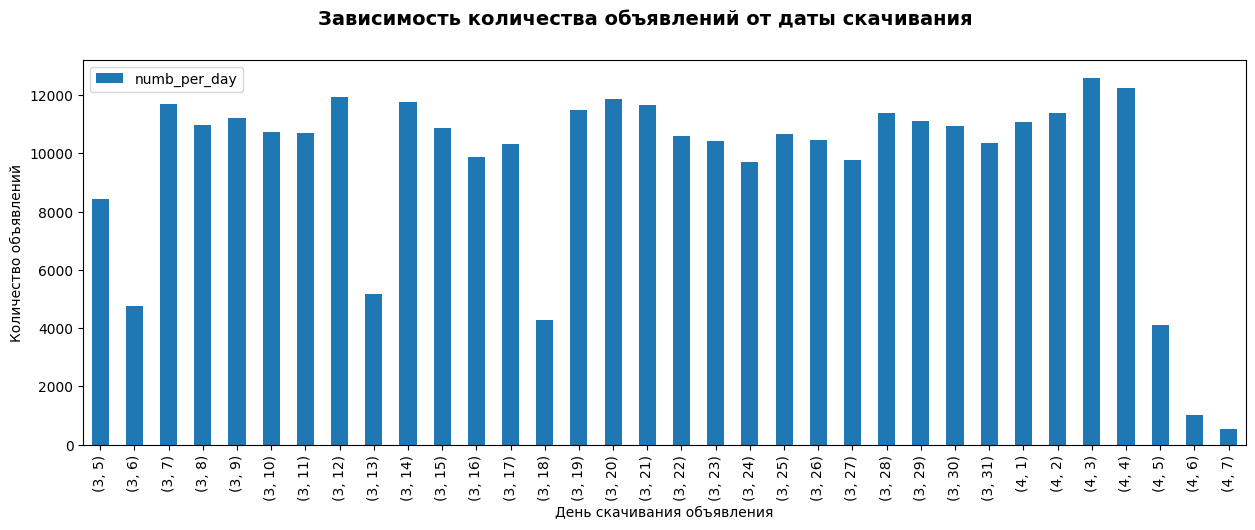

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df_by_crawled.plot(kind = 'bar', ax = axes);

fig.suptitle('Зависимость количества объявлений от даты скачивания', fontsize=14, fontweight='bold');
axes.set_xlabel("День скачивания объявления");
axes.set_ylabel("Количество объявлений"); 

In [37]:
#Медианная цена по дня скачивания
df_by_crawled = df\
.groupby(by = ['month_crawled','day_crawled'], as_index = [False, False])\
.agg(numb_per_day = ('price', 'median'))

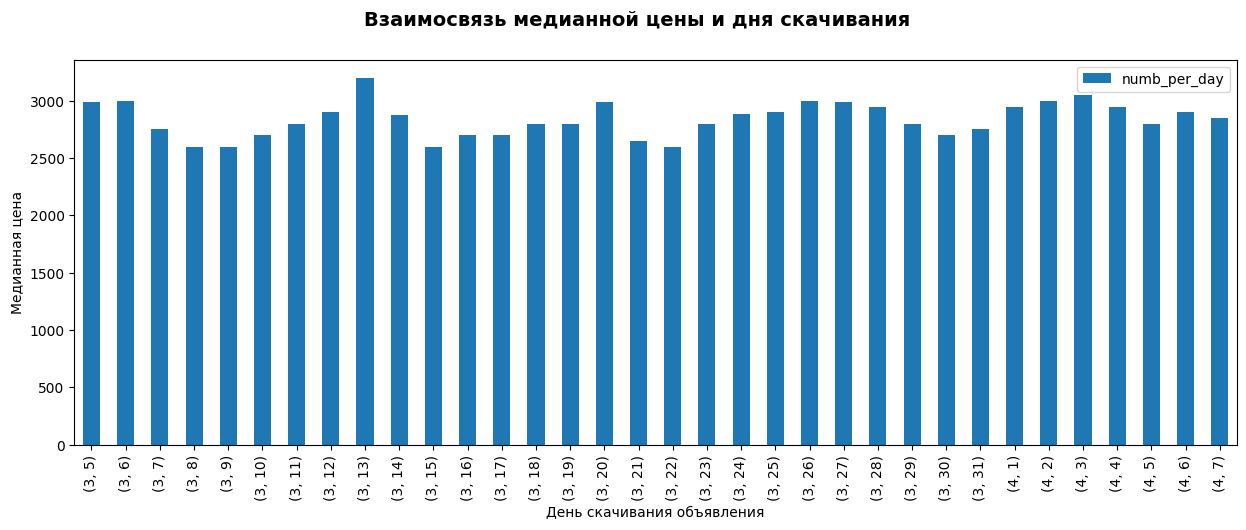

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df_by_crawled.plot(kind = 'bar', ax = axes);

fig.suptitle('Взаимосвязь медианной цены и дня скачивания', fontsize=14, fontweight='bold');
axes.set_xlabel("День скачивания объявления");
axes.set_ylabel("Медианная цена"); 

Все обяъявления скачаны в 2016 году, в марте - апреле. Сильных зависимостей между днем/месяцем скачивания и количеством объявлений не выявлено. Вместе с тем, по столбчатому графику видно, что средняя цена автомобиля зависит от дня скачивания (самые низкие цены -в пятницу, самые высокие - в понедельник-вторник). 

Однако этот признак в любом случае нельзя рассматривать как информативный применительно к решаемой задаче. Так как в случае с пользователем, рыночная цена его автомобиля не может зависеть от бады скачивания объявления из БД. Так как это не связанные процессы. Удалим все связанные с загрузкой столбцы.

In [39]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'reg_year', 'gearbox', 'power',
       'model', 'km', 'reg_month', 'fuel_type', 'brand', 'repaired',
       'numb_of_pic', 'postal_code', 'last_seen', 'day_crawled',
       'month_crawled'],
      dtype='object')

In [40]:
#Удаляем дату скачивания и вспомогательные столбцы
df = df.drop(['date_crawled', 'day_crawled', 'month_crawled'], axis = 1)

<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - хорошее решение.
</div>


### Дата последнего просмотра

In [41]:
df.last_seen.dt.year.unique()

array([2016])

In [42]:
df.last_seen.dt.month.unique()

array([4, 3])

In [43]:
#Количество последних просмотров по датам
df['day_seen'] = df.last_seen.dt.day
df['month_seen'] = df.last_seen.dt.month
df_by_seen = df\
.groupby(by = ['month_seen','day_seen'], as_index = [False, False])\
.agg(numb_per_day = ('last_seen', 'count'))

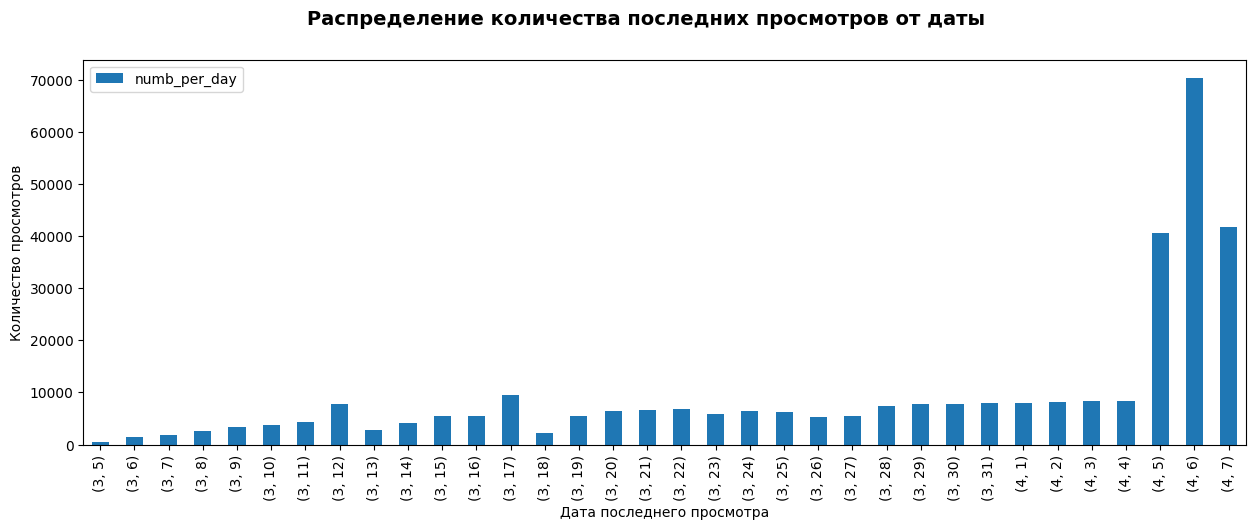

In [44]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df_by_seen.plot(kind = 'bar', ax = axes);

fig.suptitle('Распределение количества последних просмотров от даты', fontsize=14, fontweight='bold');
axes.set_xlabel("Дата последнего просмотра");
axes.set_ylabel("Количество просмотров"); 

Даты последних просмотров у большинства объявлений - 05.04.2016 -07.04.2016. В остальные даты количество последних просмотров невелико. Что наиболее вероятно означает, что большинство объявлений стабильно и регулярно просматриваются, за счет чего последняя дата просмотра близка к дате выгрузки сведений из БД. Тем не менее посмотрим, как распределена медиана цены в зависимости от дня выгрузки для указанных дат (05.04.2016 -07.04.2016)  

In [45]:
#Медианная цена по дням в промежутке 05.04.2016 -07.04.2016
df_by_seen = df\
.query('month_seen == 4 and day_seen > 4 and day_seen < 8')\
.groupby(by = ['month_seen','day_seen'], as_index = [False, False])\
.agg(price_per_day = ('price', 'median'))

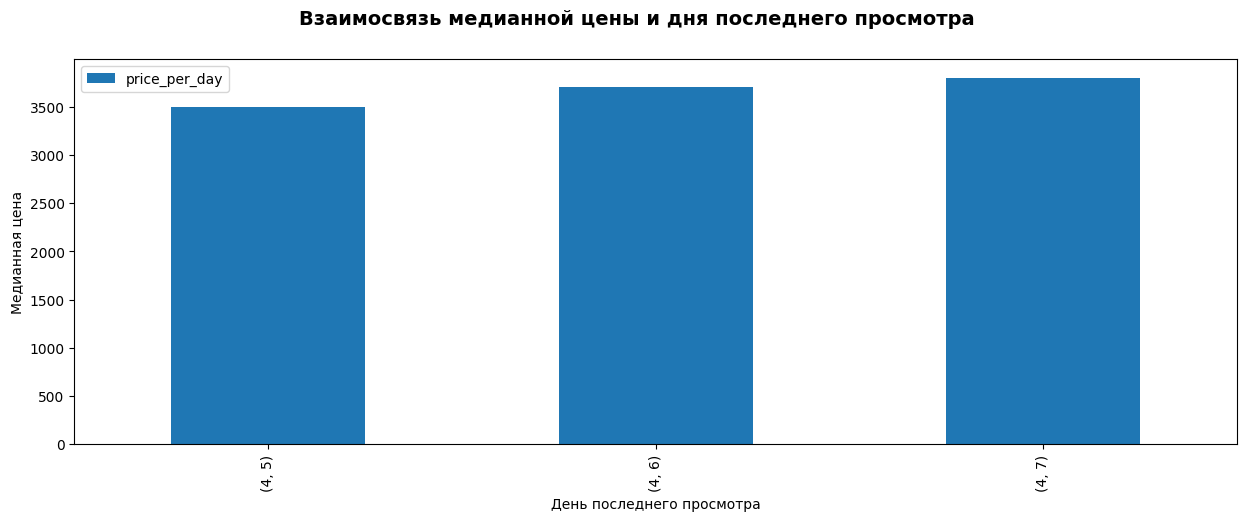

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df_by_seen.plot(kind = 'bar', ax = axes);

fig.suptitle('Взаимосвязь медианной цены и дня последнего просмотра', fontsize=14, fontweight='bold');
axes.set_xlabel("День последнего просмотра");
axes.set_ylabel("Медианная цена"); 

Таким образом, средняя цена не зависит от дня последнего просмотра. Поэтому данный столбец перед предиктивным анализом можно исключить из ДФ. 

In [47]:
#Удаляем дату последнего просмотра и вспомогательные столбцы
df = df.drop(['last_seen', 'day_seen','month_seen'] , axis = 1)

### Выводы по временным данным 

Ясно, что дата выгрузки и загрузки в БД объявления не должна влиять на стоимость автомобиля. Но графически мы видим такую зависимость. Видимо от того, что на самом деле цена зависит от даты, когда пользователь формировал объявление, которая в ДФ не представлена. Но которая наверняка связана с датой загрузки. Итого, факт выявленная указанных выше зависимостей интересен, но не полезен для исследования.  

### Изучение количественных данных

#### Количество фотографий

In [48]:
df.numb_of_pic.unique()

array([0])

 Так как в столбце количество фотографий везде стоит однои тоже значение - 0, удалим его из ДФ для оптимизации работы предиктивных моделей и памяти, занимаемой ДФ.

In [49]:
df = df.drop('numb_of_pic', axis = 1)

#### Пробег

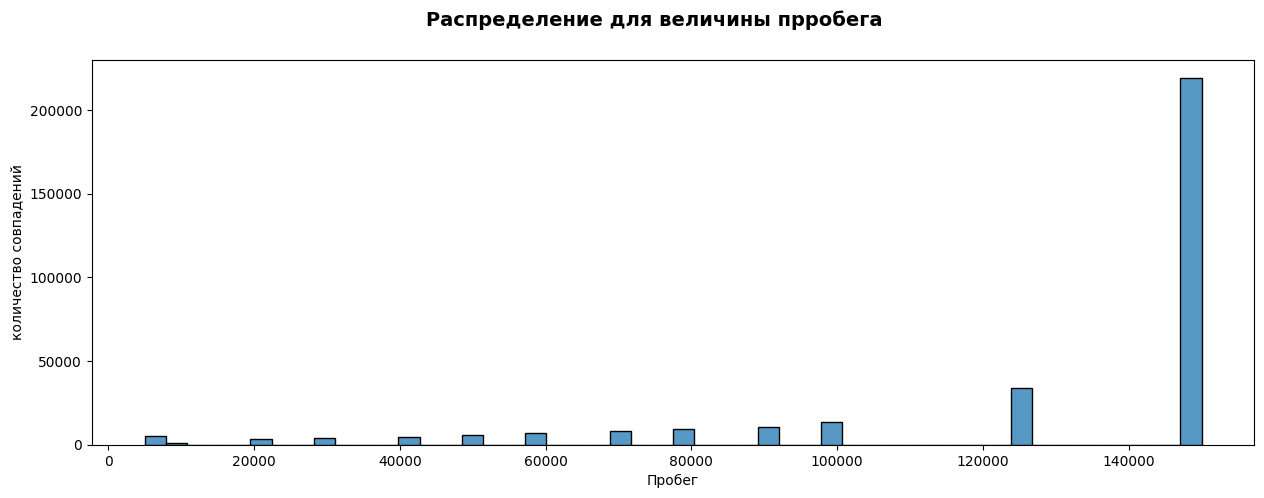

In [50]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.histplot(df.km, bins = 50, ax = axes);

fig.suptitle('Распределение для величины прробега', fontsize=14, fontweight='bold');
axes.set_xlabel("Пробег");
axes.set_ylabel("количество совпадений"); 

На первый взгляд кажеться, что распределение величины пробега исскуственно искажено и из предполагаемого непрерывного приведено к дискретному. Возможно сервис по продаже округляет пробег до круглых значений. Проверим, так ли это, построив диаграмму рассеяния

In [51]:
group_by_km = df\
.groupby(by = 'km', as_index = False)\
.agg(numb_of_rec = ('km', 'count'))

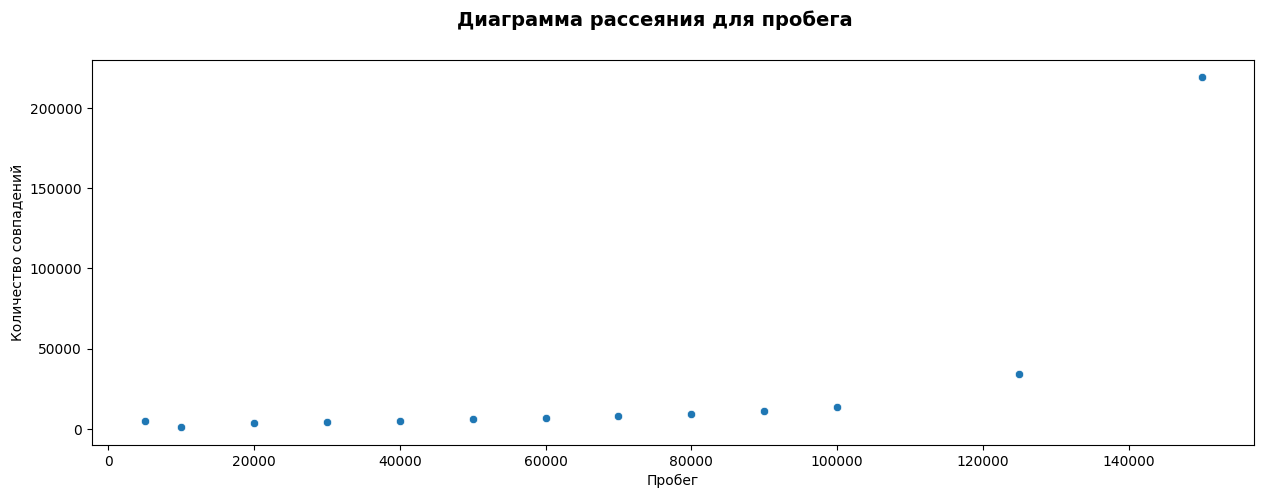

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.scatterplot(data = group_by_km, x = 'km', y = 'numb_of_rec', ax = axes);

fig.suptitle('Диаграмма рассеяния для пробега', fontsize=14, fontweight='bold');
axes.set_xlabel("Пробег");
axes.set_ylabel("Количество совпадений"); 

Действительно, величины пробега создана из комбинации 13 значений. В данном случае странно не это, а то, что большинство авто имеет величину пробега, равную 150000 км. Такой всплеск как минимум должен вызвать вопросы. Единственное объяснение - у всех авто, с пробегом более 140 000 приравнивается к 150 000. В идеале, необходимо уточнить с чем может быть связана выявленная аномалия у заказчика. Посмотрим, как связана средняя цена и пробег.

In [53]:
group_by_km = df\
.groupby(by = 'km', as_index = False)\
.agg(price = ('price', 'median'))

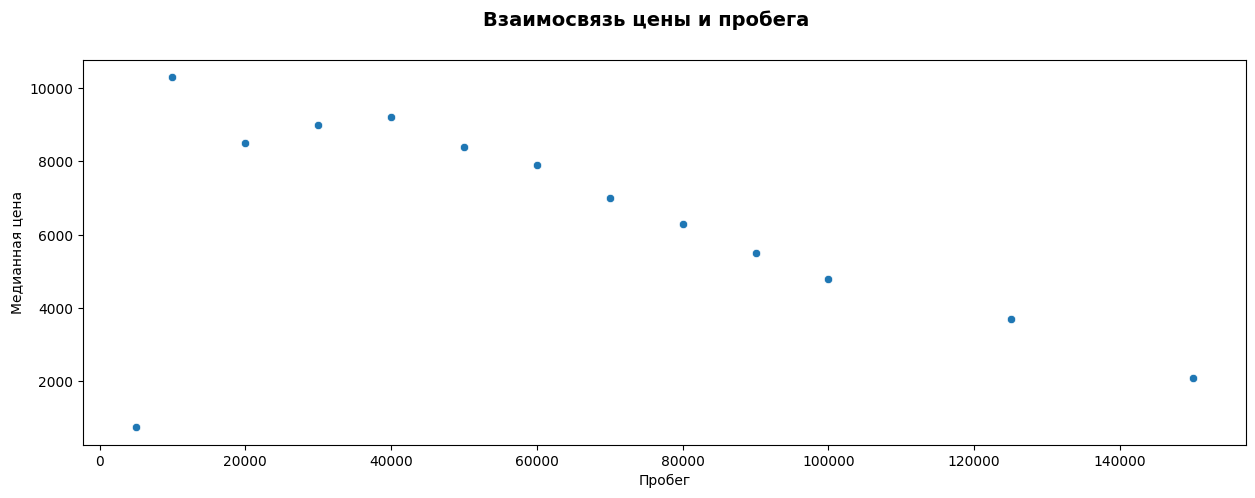

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.scatterplot(data = group_by_km, x = 'km', y = 'price', ax = axes);

fig.suptitle('Взаимосвязь цены и пробега', fontsize=14, fontweight='bold');
axes.set_xlabel("Пробег");
axes.set_ylabel("Медианная цена"); 

График деманстрирует ожидаемую зависимость: при увеличении пробега средняя цена уменьшается. Вместе с тем на графике есть точка, координально отклоняющаяся от ожидаемой зависимости, в которой пробег равен 5000 км. Сделаем выгрузку по связанным с ней записям  

In [55]:
df.query('km == 5000').sort_values(by = 'price').price.unique()[:100]

array([  0,   1,   2,   5,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  20,  25,  29,  30,  32,  35,  39,  40,  45,  49,
        50,  55,  59,  60,  65,  69,  70,  74,  75,  79,  80,  85,  90,
        95,  99, 100, 101, 105, 110, 111, 120, 125, 130, 139, 140, 149,
       150, 160, 162, 165, 170, 175, 177, 179, 180, 190, 195, 199, 200,
       209, 210, 220, 222, 225, 230, 233, 235, 240, 245, 249, 250, 260,
       266, 272, 275, 280, 285, 290, 293, 295, 299, 300, 309, 320, 323,
       333, 340, 349, 350, 355, 360, 365, 373, 380])

Мы видим,что в разделе цена присутсвует явно ложные значения - 0.03, 1.003, 2.003 ...Исходя из здравого смысла мы можем предположить, что в отдельных редких случаях машина с маленьким пробегом (5000) может продаваться дешево. Но в среднем так не должно быть. Значит в данных содержиться глобальная ошибка. Так же мы можем предположить, что машина,имеющая пробег 5000 км - это почти новая машина и для нее у пользователей не возникнет потребность определять рыночную стоимость. Поэтому удалим строки, где пробег равен 5000 км, а цена меньше 20000.

In [56]:
df.query('(km == 5000 and price < 20000)').km.count()

4949

In [57]:
df = df.query('~(km == 5000 and price < 20000)')

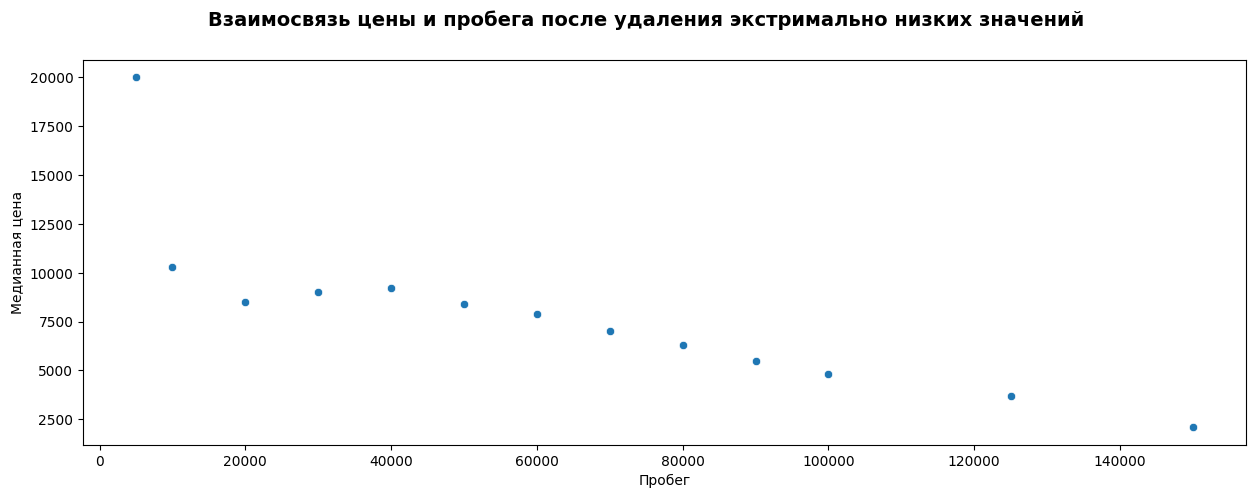

In [58]:
group_by_km = df\
.groupby(by = 'km', as_index = False)\
.agg(price = ('price', 'median'))

fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.scatterplot(data = group_by_km, x = 'km', y = 'price', ax = axes);

fig.suptitle('Взаимосвязь цены и пробега после удаления экстримально низких значений', fontsize=14, fontweight='bold');
axes.set_xlabel("Пробег");
axes.set_ylabel("Медианная цена"); 

#### Мощность двигателя

Мощность двигателя должна быть в диапазоне от 20 до 500 лс, остальное - экзотика или ошибочные значения

In [59]:
print("Слишком большие значения: \n", \
      df.query('power > 500').power.sort_values(ascending = False).unique(),
      "\n Количество слишком больших значений: \n",
      df.query('power > 500').power.sort_values(ascending = False).count(),
     )

print("Слишком маленькие значения: \n", \
      df.query('power < 20 and power > 0').power.sort_values(ascending = False).unique(),
       "\n Количество слишком маленьких значений: \n",
      df.query('power < 20 and power > 0').power.sort_values(ascending = False).count(),
     )

print("Количество нулевых значений: \n",
      df.query('power == 0').power.sort_values(ascending = False).count(),
     )

Слишком большие значения: 
 [20000 19312 19211 19208 17932 17700 16312 16311 15020 15017 15001 14009
 13636 12512 12510 12012 11635 11530 11509 11111 11025 11011 10912 10910
 10710 10522 10520 10317 10218 10110  9710  9012  9007  8500  8404  8259
  8011  7544  7529  7518  7515  7512  7511  7508  6920  6512  6226  6062
  6045  6018  6012  6010  6006  5867  5815  5809  5575  5420  5411  5000
  4700  4400  3750  3500  3454  3199  2799  2792  2789  2729  2598  2461
  2402  2389  2340  2331  2200  2172  2018  2017  2016  2009  2007  2005
  2004  2000  1999  1998  1995  1993  1992  1988  1968  1937  1933  1922
  1920  1910  1900  1896  1895  1870  1801  1800  1799  1796  1793  1783
  1781  1780  1771  1753  1707  1704  1703  1701  1700  1689  1659  1653
  1631  1625  1600  1598  1597  1596  1595  1548  1521  1506  1503  1502
  1501  1500  1436  1433  1432  1416  1405  1403  1401  1400  1399  1390
  1367  1363  1362  1360  1339  1317  1312  1299  1288  1275  1256  1250
  1241  1240  1239  123

В ДФ присутсвует записи, в которых зафиксирована некоррктные значения мощностей двигателя:
- в 363 записях мощность двигателей слишком большая (> 500 лс);
- в 250 записях мощность двигателей слишком маленькая (< 20 лс);
- в 30055 записях мощность двигателей нулевая

Удалим из ДФ слишком большие и слишком маленькие значения, а нулевые значения оставим, так как их слишком много и наиболее вероятно они означают, что мощность двигателя просто не была указана. 

In [60]:
df = df.query('power > 20 and power < 500')

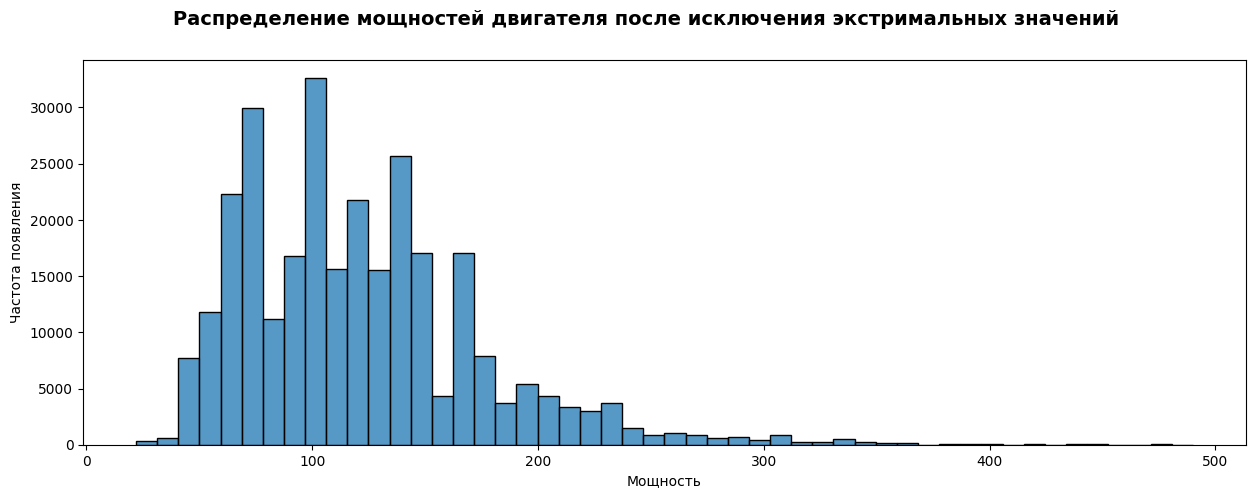

In [61]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.histplot(df.power, bins = 50, ax = axes);

fig.suptitle('Распределение мощностей двигателя после исключения экстримальных значений', fontsize=14, fontweight='bold');
axes.set_xlabel("Мощность");
axes.set_ylabel("Частота появления"); 

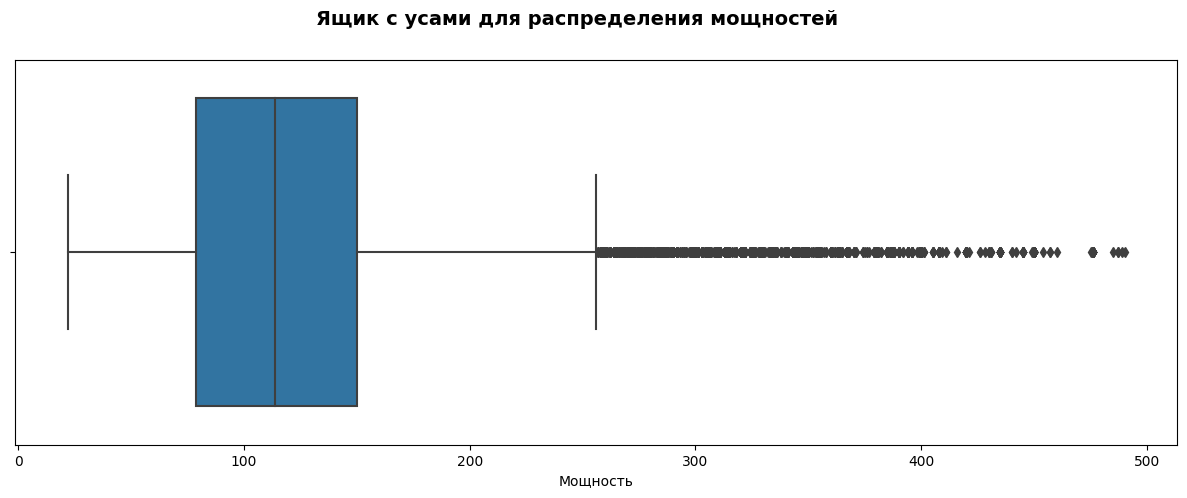

In [62]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.boxplot(data = df, x ='power', ax = axes);

fig.suptitle('Ящик с усами для распределения мощностей', fontsize=14, fontweight='bold');
axes.set_xlabel("Мощность");
axes.set_ylabel(""); 

Теперь распределение для мощности двигателей выглядит правдоподобно. Посмотрим как соотносятся медианная цена автомобиля и мощность двигателя

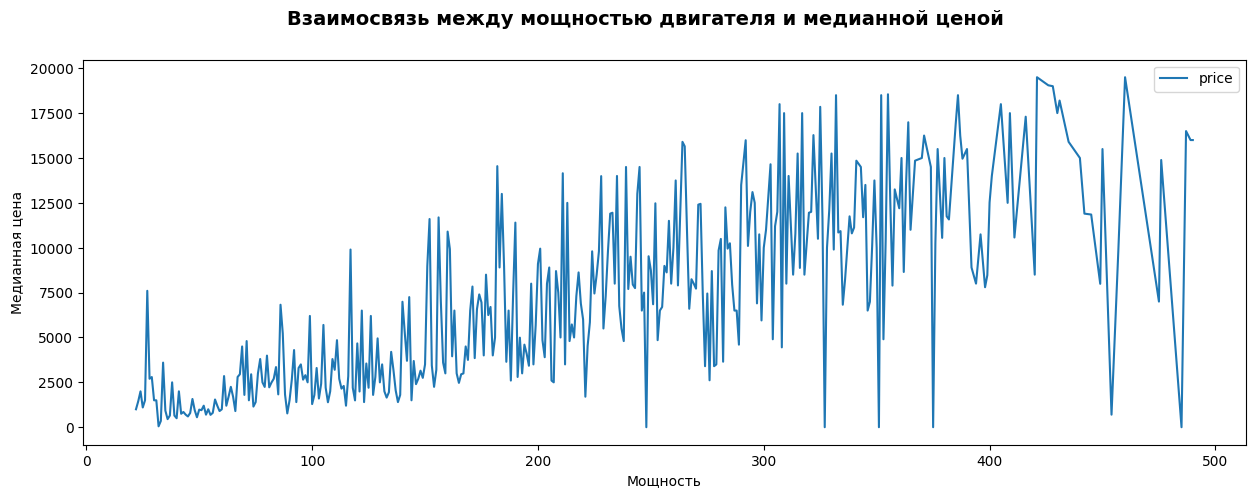

In [63]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df.groupby(by = 'power').agg(price = ('price', 'median')).plot(ax = axes);

fig.suptitle('Взаимосвязь между мощностью двигателя и медианной ценой', fontsize=14, fontweight='bold');
axes.set_xlabel("Мощность");
axes.set_ylabel("Медианная цена"); 

Построенный график демонстрирует ожидаемое поведение - цена растет с увеличением мощности.

#### Тип кузова

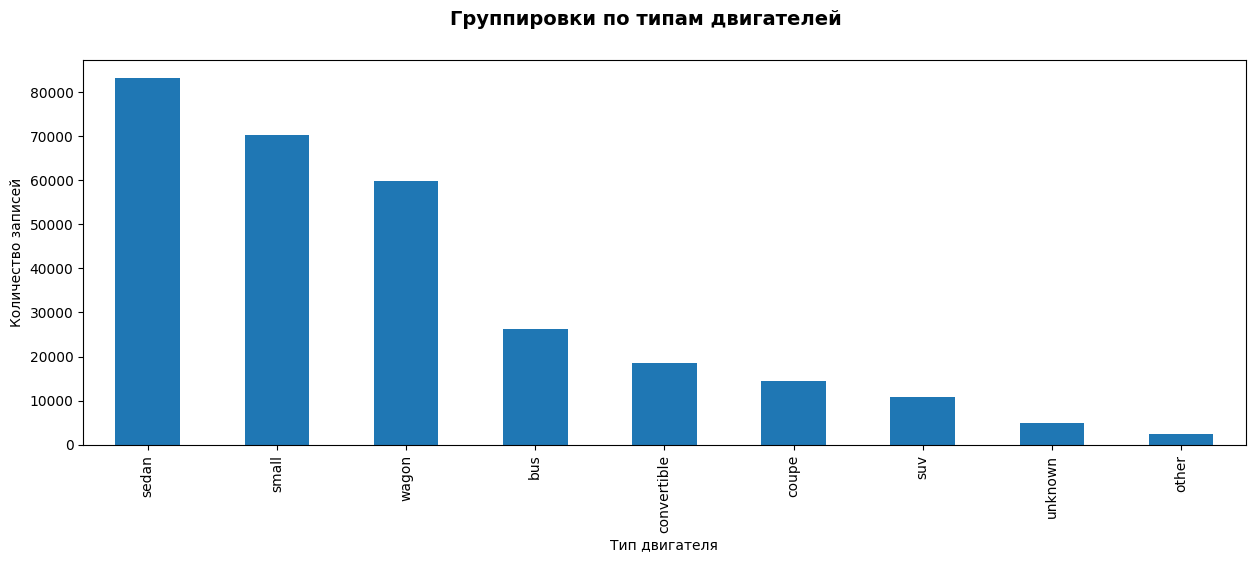

In [64]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df.groupby(by = 'vehicle_type').vehicle_type.count().sort_values(ascending = False).\
plot(kind = 'bar', xlabel = 'Тип двигателя', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по типам двигателей', fontsize=14, fontweight='bold');
axes.set_xlabel("Тип двигателя");
axes.set_ylabel("Количество записей"); 

Тип кузова номинативная величина, которую для корректной работы машинных моделей необходимо закодировать. С одной стороны, чтобы избежать исскуственного ранжирования необходимо использовать метод однопроходного кодирования (one-hot-encoder). С другой стороны использование указанного метода приведет к расширению данных на 9 колонок, что увеличит вычислительную сложность маричных и иных операций. Поэтому предлагаю использовать третий вариант. Выяснить, отсортировать типы кузовов по медианной стоимости и закодировать их самостоятельно 

In [65]:
#Сортируемтипы кузовов по возрастанию медианной цены
vehicle_for_rang = df.groupby(by = 'vehicle_type', as_index = False)\
.agg(median_price = ('price', 'median'))\
.sort_values(by = 'median_price', ascending = True).vehicle_type

#Трансформируем сгруппированные данные, чтобы название было индексом, а порядковый номер столбцом
vehicle_for_rang = vehicle_for_rang.reset_index()
vehicle_for_rang['index'] = vehicle_for_rang.index
vehicle_for_rang.index = vehicle_for_rang.vehicle_type

In [66]:
#Кодируем столбец с типом кузова и удаляем категориальный столбнц
df['vehicle_kat'] = df.vehicle_type
df['vehicle_kat'] = df.vehicle_kat.apply(lambda x: vehicle_for_rang.loc[x, 'index'])

####  Тип коробки передач

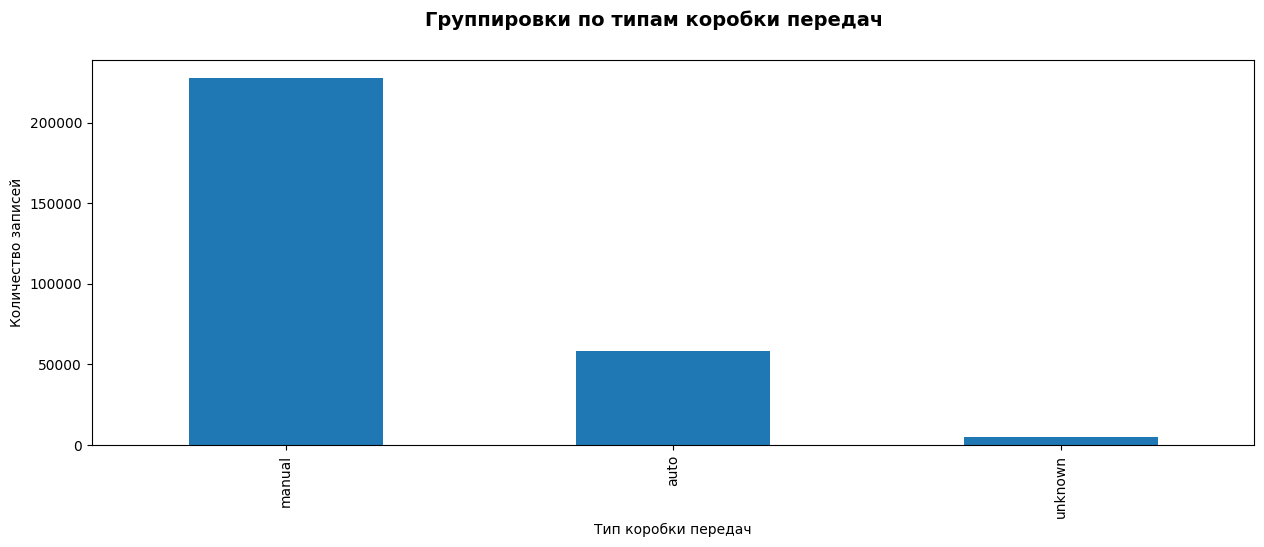

In [67]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df.groupby(by = 'gearbox').gearbox.count().sort_values(ascending = False).\
plot(kind = 'bar', xlabel = 'Тип коробки', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по типам коробки передач', fontsize=14, fontweight='bold');
axes.set_xlabel("Тип коробки передач");
axes.set_ylabel("Количество записей"); 

Тип коробки передач номинативная величина, которую для корректной работы машинных моделей необходимо закодировать. В этом случае, чтобы избежать исскуственного ранжирования целесообразно использовать метод однопроходного кодирования (one-hot-encoder). 

####  Типы топлива

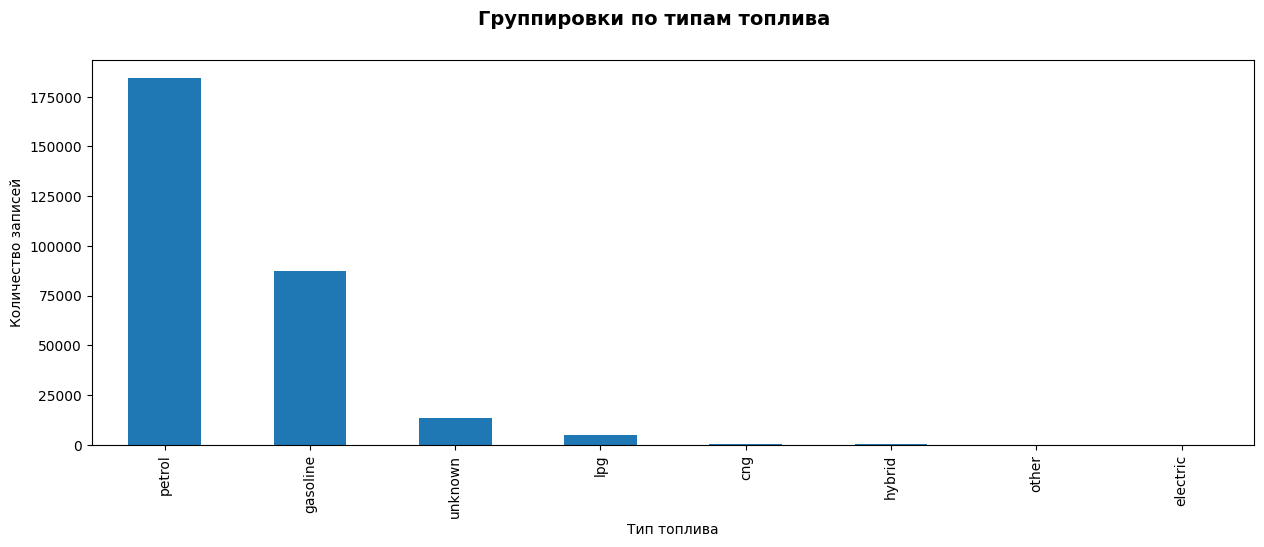

In [68]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df.groupby(by = 'fuel_type').fuel_type.count().sort_values(ascending = False).\
plot(kind = 'bar', xlabel = 'Тип топлива', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по типам топлива', fontsize=14, fontweight='bold');
axes.set_xlabel("Тип топлива");
axes.set_ylabel("Количество записей"); 

Проверим, какова степень влияния типа топлива на зависимый признак

In [69]:
pois = sf.glm('price ~ C(fuel_type) + C(gearbox)+C(vehicle_type)+C(repaired)', \
              family = sm.families.Poisson(), data = df).fit()
pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:               290510
Model:                            GLM   Df Residuals:                   290490
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.2224e+08
Date:                Sat, 13 May 2023   Deviance:                   8.4168e+08
Time:                        13:25:23   Pearson chi2:                 9.54e+08
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          8.9308      0.001   1.33e+04      0.000       8.929       8.932
C(fuel_type)[T.electric]           0.4445      0.002    230.491      0.000       0.441       0.448
C(fuel_type)[T.gasoline]           0.2471      0.001    368.093      0.000       0.246       0.248
C(fuel_type)[T.hybrid]             0.4473      0.001    459.875      0.000       0.445       0.449
C(fuel_type)[T.lpg]               -0.2958      0.001   -417.825      0.000      -0.297      -0.294
C(fuel_type)[T.other]             -0.3920      0.002   -175.280      0.000      -0.396      -0.388
C(fuel_type)[T.petrol]            -0.2038      0.001   -303.229      0.000      -0.205      -0.202
C(fuel_type)[T.unknown]           -0.3941      0.001   -569.096      0.000      -0.395      -0.393
C(gearbox)[T.manual]              -0.3405    6.1e-05  -5578.683      0.000      -0.341      -0.340
C(gearbox)[T.unknown]             -0.4821      0.000  -1760.651      0.000      -0.483      -0.482
C(vehicle_type)[T.convertible]     0.4079      0.000   3217.547      0.000       0.408       0.408
C(vehicle_type)[T.coupe]           0.2659      0.000   1911.650      0.000       0.266       0.266
C(vehicle_type)[T.other]          -0.2169      0.000   -622.563      0.000      -0.218      -0.216
C(vehicle_type)[T.sedan]          -0.0294   9.86e-05   -298.481      0.000      -0.030      -0.029
C(vehicle_type)[T.small]          -0.3883      0.000  -3387.148      0.000      -0.388      -0.388
C(vehicle_type)[T.suv]             0.3893      0.000   2972.684      0.000       0.389       0.390
C(vehicle_type)[T.unknown]        -0.2364      0.000   -775.065      0.000      -0.237      -0.236
C(vehicle_type)[T.wagon]          -0.0944      0.000   -938.483      0.000      -0.095      -0.094
C(repaired)[T.unknown]            -0.4729   9.63e-05  -4909.066      0.000      -0.473      -0.473
C(repaired)[T.yes]                -0.8787      0.000  -6593.102      0.000      -0.879      -0.878
==================================================================================================
"""

Так как уровень влияния номинативной переменной "тип топлива"(fuel_type) не оказывает статистически значимого влияния на цену (p-value -> 0), для оптимизации дальнейших исследований и расчетов можно:
1. Объединить малочислинные страты (все кроме petrol и gasoline) в одну (other)
2. В процессе предиктивной аналитики данные о типе топлива не использовать

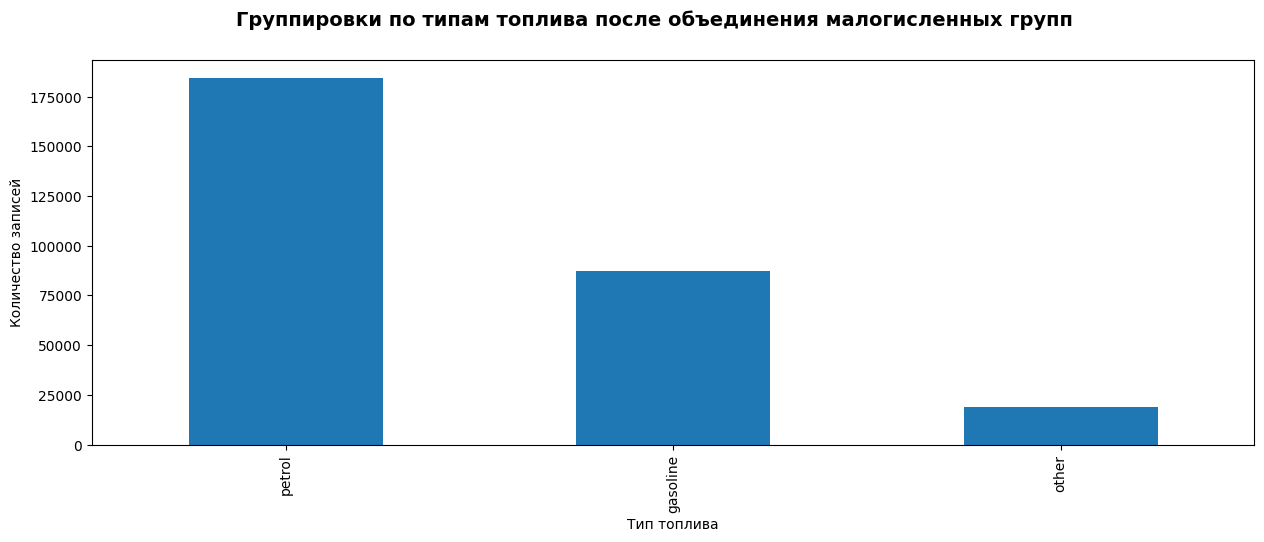

In [70]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df['fuel_type'] = df.fuel_type.transform(lambda x: x if x in ['petrol','gasoline'] else 'other') 
df.groupby(by = 'fuel_type').fuel_type.count().sort_values(ascending = False).\
plot(kind = 'bar', xlabel = 'Тип топлива', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по типам топлива после объединения малогисленных групп', fontsize=14, fontweight='bold');
axes.set_xlabel("Тип топлива");
axes.set_ylabel("Количество записей"); 

Тип коробки передач номинативная величина, которую для корректной работы машинных моделей необходимо закодировать. Так как на этапе EDA мы снизили вариативность переменной до трех состояний, для ее кодирования можно применить метод метод однопроходного кодирования (one-hot-encoder). 

#### Брэнды автомобилей

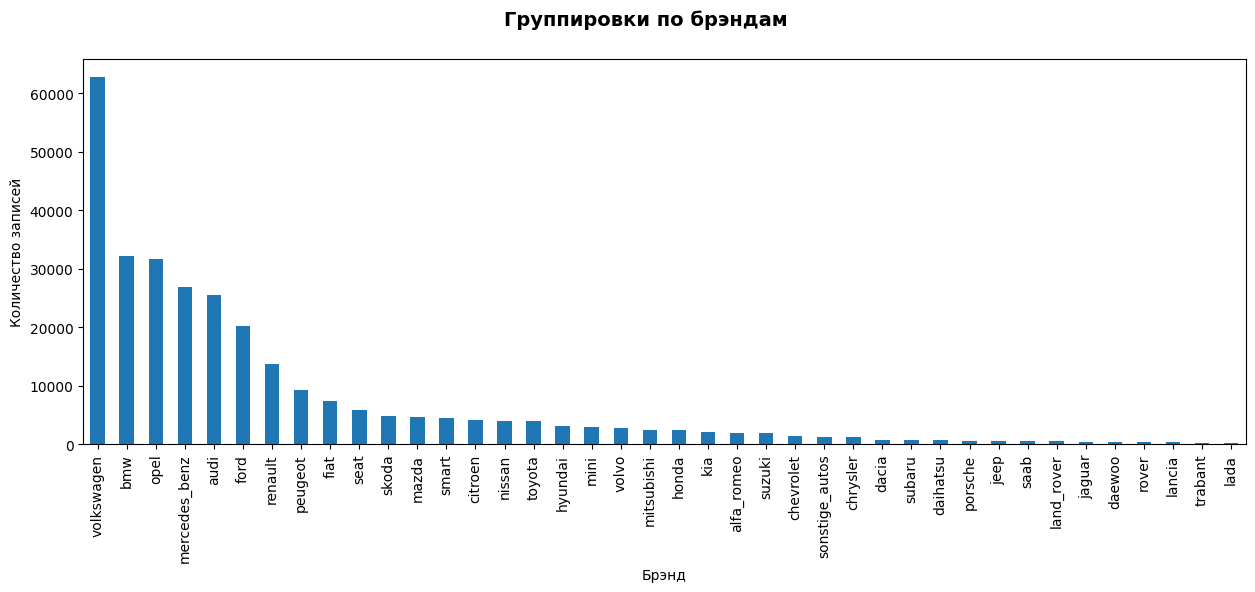

In [71]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

df.groupby(by = 'brand').brand.count().sort_values(ascending = False).\
plot(kind = 'bar', xlabel = 'Брэнд', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по брэндам', fontsize=14, fontweight='bold');
axes.set_xlabel("Брэнд");
axes.set_ylabel("Количество записей"); 

Неявные дубликаты в столбце brand отсутсвуют. В ДФ представлено 40 уникальных брендов. По гистограмме видно, что абсолютное количество проданных автомабилей у брендов из топ-10 в 2 и более раз превышает число машин,проданных среди остальных брендов. 
Для оптимизации дальнейших исследований и расчетов можно:
1. Посчитать среднюю(медианную) стоимость продажи для каждого бренда
2. Малочисленные брэнды, с бюджетной стоимостью (1 квартиль и ниже) объединить в одну группу (other_lp)
3. Малочисленные брэнды, с дорогой стоимостью (3 квартиль и выше) объединить в одну группу (other_hp)
4. Малочисленные брэнды, со средней стоимостью (2 квартиль) объединить в одну группу (other_mp)

In [72]:
#Ценовые квантили повсейвыборке
q1 = df.price.describe()['25%']
q3 = df.price.describe()['75%']

#Медианы цен побрэндам
mprice_by_brand = df.groupby(by ='brand').price.median().sort_values(ascending = False)

#Топ-10 самых продающихся брэндов 
top_sels = df.groupby(by = 'brand').brand.count().sort_values(ascending = False).head(35)

In [73]:
#Стратификация малопродающихся брэндов по медианной стоимости
df['group_brand'] = df.brand
df.group_brand = df.group_brand.transform\
(lambda x:(\
           (x in top_sels.index and x) or \
           (mprice_by_brand[x] < q1 and 'other_lp') or \
           (mprice_by_brand[x] > q3 and 'other_hp') or \
            'other_mp'
          )
)

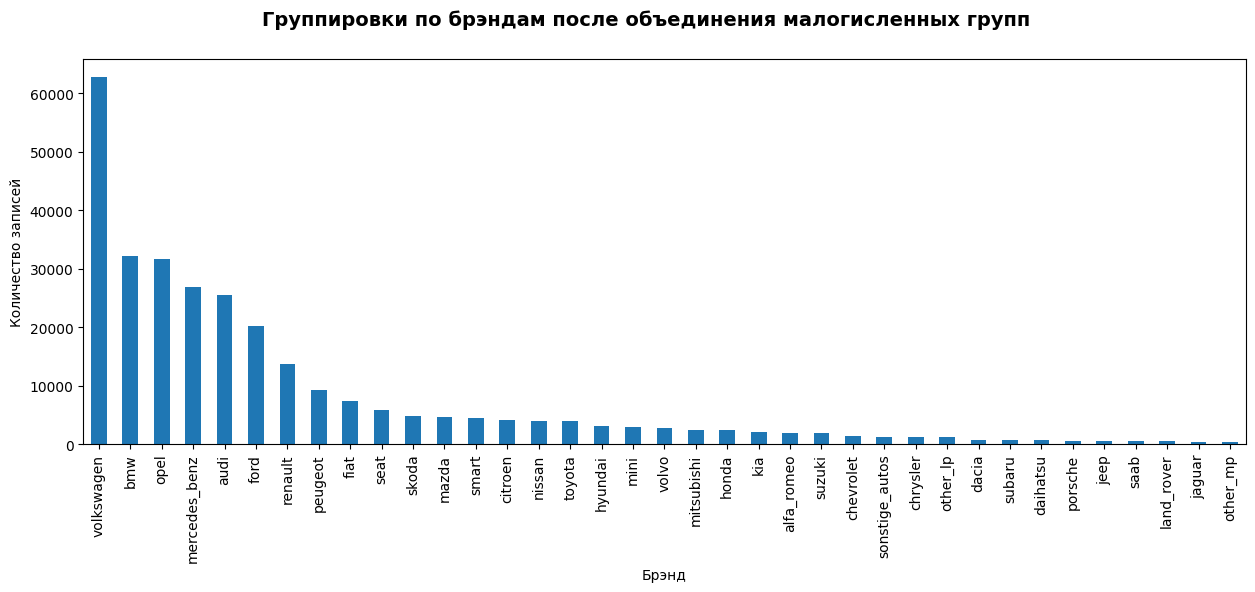

In [74]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

#Полученное распределение продаж по группам брэндов
df.groupby(by = 'group_brand').group_brand.count().sort_values(ascending = False).\
plot(kind = 'bar', xlabel = 'Брэнды', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по брэндам после объединения малогисленных групп', fontsize=14, fontweight='bold');
axes.set_xlabel("Брэнд");
axes.set_ylabel("Количество записей"); 

Объединение самых малопродающихся брэндов  позволило нам несколько снизить вариативность рассматриваемой номинативной переменной, но число вариантов все же слишком большое дляиспользования техники однопроходного кодирования, поэтому применим для кодирования использованный ранее для столбца тип кузова подход.

In [75]:
#Сортируем брэнды по возрастанию медианной цены
brand_for_rang = df.groupby(by = 'group_brand', as_index = False)\
.agg(median_price = ('price', 'median'))\
.sort_values(by = 'median_price', ascending = True).group_brand

#Трансформируем сгруппированные данные, чтобы название было индексом, а порядковый номер столбцом
brand_for_rang = brand_for_rang.reset_index()
brand_for_rang['index'] = brand_for_rang.index
brand_for_rang.index = brand_for_rang.group_brand

In [76]:
#Кодируем столбец с брэндом
df['brand_kat'] = df.group_brand
df['brand_kat'] = df.brand_kat.apply(lambda x: brand_for_rang.loc[x, 'index'])

#### Марки автомобилей

In [77]:
df.model.nunique()

249

В ДФ всего 249 моделей авто. Модели, которые относятся к брэндам из стратифицированных групп (other_lp, other_hp, other_mp) так же преобразуем к аналогичным названиям 

In [78]:
lp_list = list(df.query('group_brand == "other_lp"').model.unique())
hp_list = list(df.query('group_brand == "other_hp"').model.unique())
mp_list = list(df.query('group_brand == "other_mp"').model.unique())

In [79]:
#Стother_lpратификация моделей малопродающихся брэндов по названиям групп брэндов
df['group_model'] = df.model
df.group_model = df.group_model.apply\
(lambda x:(\
           (x in lp_list and 'other_lp') or \
           (x in hp_list and 'other_hp') or \
           (x in mp_list and 'other_mp') or \
            x
          )
)

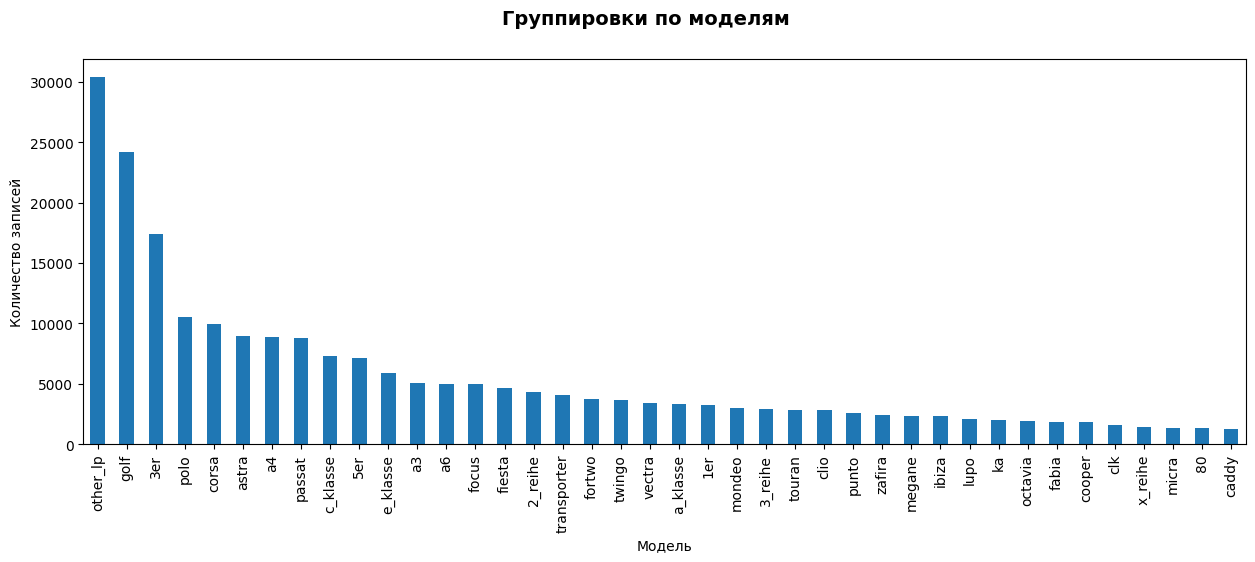

In [80]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

#Полученное распределение продаж по группам моделей
df.groupby(by = 'group_model').group_model.count().sort_values(ascending = False).head(40)\
.plot(kind = 'bar', xlabel = 'Модели', ylabel = 'Количество записей', ax = axes);

fig.suptitle('Группировки по моделям', fontsize=14, fontweight='bold');
axes.set_xlabel("Модель");
axes.set_ylabel("Количество записей"); 

В ДФ представлено 249 уникальных брендов. По гистограмме видно, что наиболее продаваемые марки автомобилей golf и 3er. Остальные продавались в 1.5 и более раз реже. Модели, стратофицированные по принадлежности к сгруппированным брэндам (кроме группы в которую изначально вошла группа other не попали в топ-40, значит вероятность появления новой записи с моделями из этих групп крайне мала. Полученная группировка не должна ухудшить качество моделей анализа рыночной стоимости. 

С другой стороны объединение моделей внутри самых малопродающихся брэндов позволило нам несколько снизить вариативность рассматриваемой номинативной переменной, но число вариантов все же слишком большое для использования техники однопроходного кодирования, поэтому применим для кодирования использованный ранее для столбцов тип кузова и брэнд подход

In [81]:
#Сортируем модели по возрастанию медианной цены
model_for_rang = df.groupby(by = 'group_model', as_index = False)\
.agg(median_price = ('price', 'median'))\
.sort_values(by = 'median_price', ascending = True).group_model

#Трансформируем сгруппированные данные, чтобы название было индексом, а порядковый номер столбцом
model_for_rang = model_for_rang.reset_index()
model_for_rang['index'] = model_for_rang.index
model_for_rang.index = model_for_rang.group_model

In [82]:
#Кодируем столбец с брэндом
df['model_kat'] = df.group_model
df['model_kat'] = df.model_kat.apply(lambda x: model_for_rang.loc[x, 'index'])

#### Почтовый индекс владельца анкеты

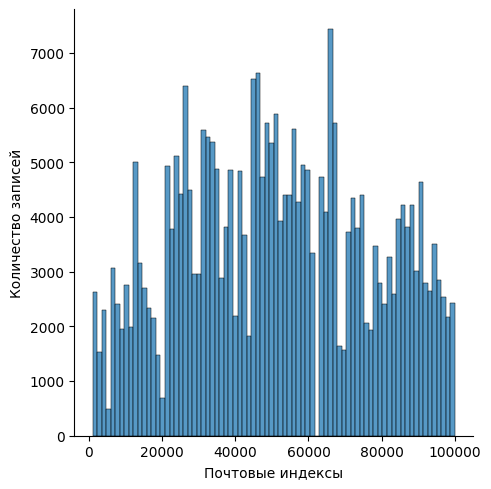

In [83]:
fig = sns.displot(df.postal_code, kde=False);
fig.set_axis_labels("Почтовые индексы", "Количество записей");


По гистограмме видно, что в ДФ представлены записи объявлений от пользователей с разными почтовыми индексами.

#### Цена

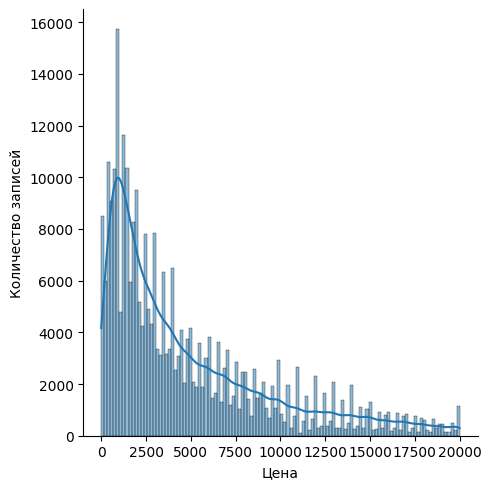

In [84]:
#Распределение цены
fig = sns.displot(df.price, kde=True);
fig.set_axis_labels("Цена", "Количество записей");

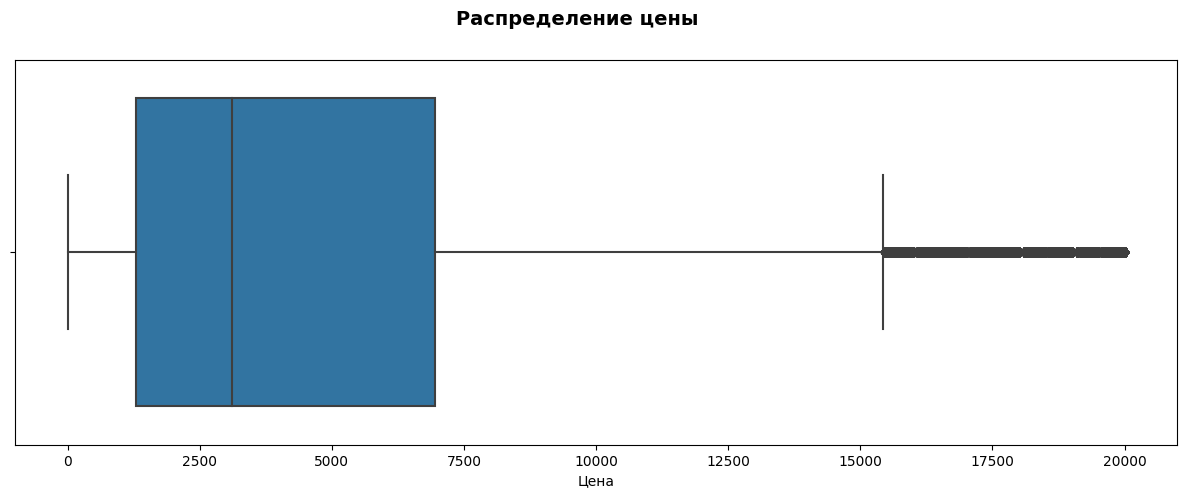

In [85]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.boxplot(data = df, x = 'price', ax = axes);

fig.suptitle('Распределение цены', fontsize=14, fontweight='bold');
axes.set_xlabel("Цена");
axes.set_ylabel(""); 

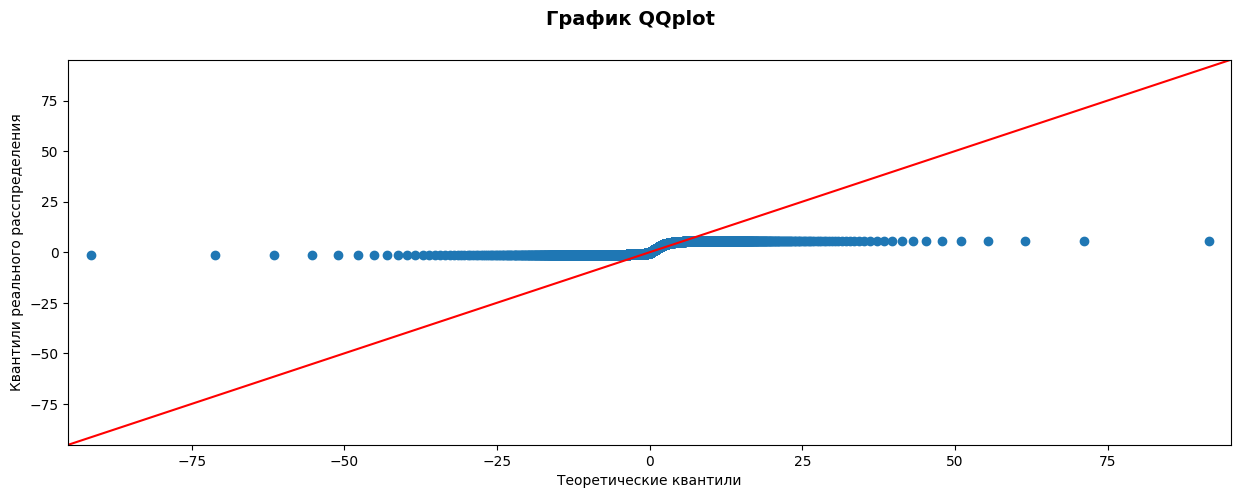

In [86]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

fig = sm.qqplot(df.price, stats.t, fit=True, line="45", ax = axes)

fig.suptitle('График QQplot', fontsize=14, fontweight='bold');
axes.set_xlabel("Теоретические квантили");
axes.set_ylabel("Квантили реального расспределения"); 

Внешне распределение цены напоминает Пуассоновское. Вместе с тем для моделей линейной регрессии требуется, чтобы целевая пременная имела близкое к нормальному распределению. Попробуем применить функцию связи для преобразования целевой переменной и "трансформации" распределения. Наиболее подходящей вероятнее всего будет функция логарифма, так как ее использование считается предпочтительным, когда в целовой переменной много маленьких значений и мало больших.

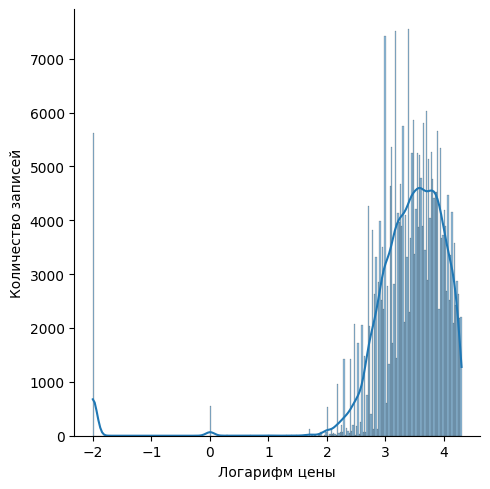

In [89]:
#Распределение логарифма целевой переменной
df['log_price'] = np.log10(df.price + 0.01)
fig = sns.displot(df.log_price, kde=True);
fig.set_axis_labels("Логарифм цены", "Количество записей");

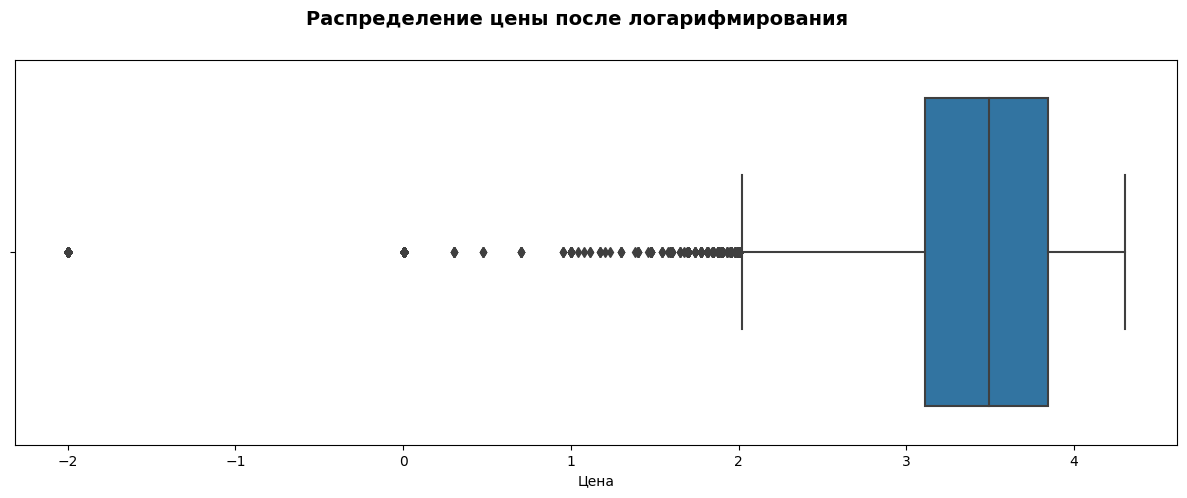

In [90]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.boxplot(data = df, x = 'log_price', ax = axes);

fig.suptitle('Распределение цены после логарифмирования', fontsize=14, fontweight='bold');
axes.set_xlabel("Цена");
axes.set_ylabel(""); 

По боксплоту видно, что распределение стало намного более симметричным внутри 1-2 квартиля и в нем целом приблизилось к нормальному. Однако выбросы за пределами 75 персентили конечно негативно скажутся на предсказаниях модели. Протестируем распределение на нормальность с помощью графика QQplot.

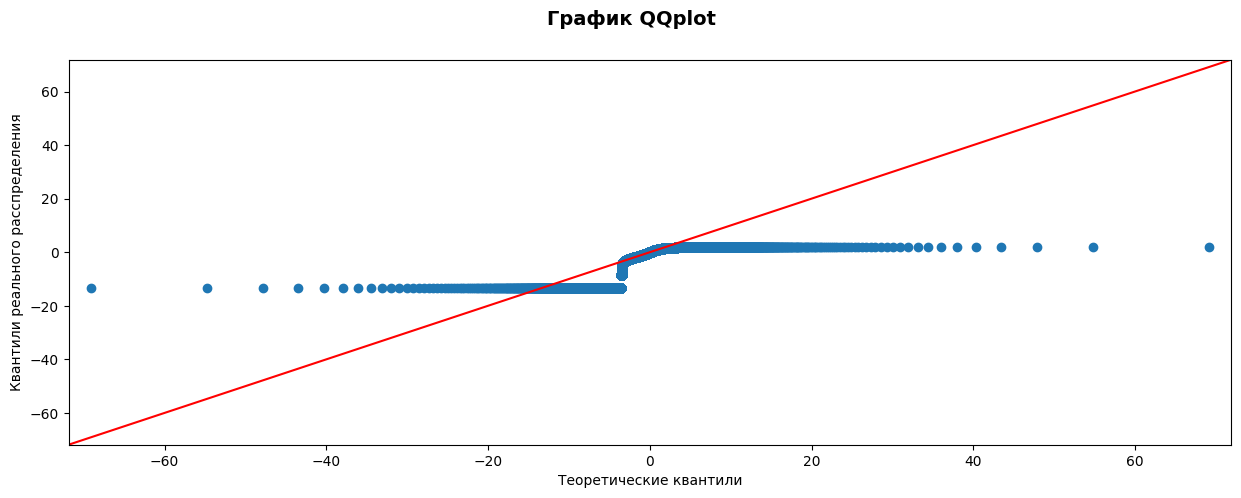

In [91]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

fig = sm.qqplot(df.log_price, stats.t, fit=True, line="45", ax = axes)

fig.suptitle('График QQplot', fontsize=14, fontweight='bold');
axes.set_xlabel("Теоретические квантили");
axes.set_ylabel("Квантили реального расспределения"); 

По графику qqplot видно, что даже после преобразования распределение цены все же не стало нормальным. Фактически оно близко к нормальному в узком диапазоне. А значит обучить качественно линейные модели вряд-ли удастся. 

Чтобы распределение стало более нормальным,удалим околонулевые цены автомобилей, так как природа их появления не объяснима и скорее всего ошибочна.  

In [92]:
df = df.query('price > 5')
df['log_price'] = np.log10(df.price)

<ipython-input-92-6109236af2fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_price'] = np.log10(df.price)


Посмотри как распределена цена в зависимости от номинативных переменных 

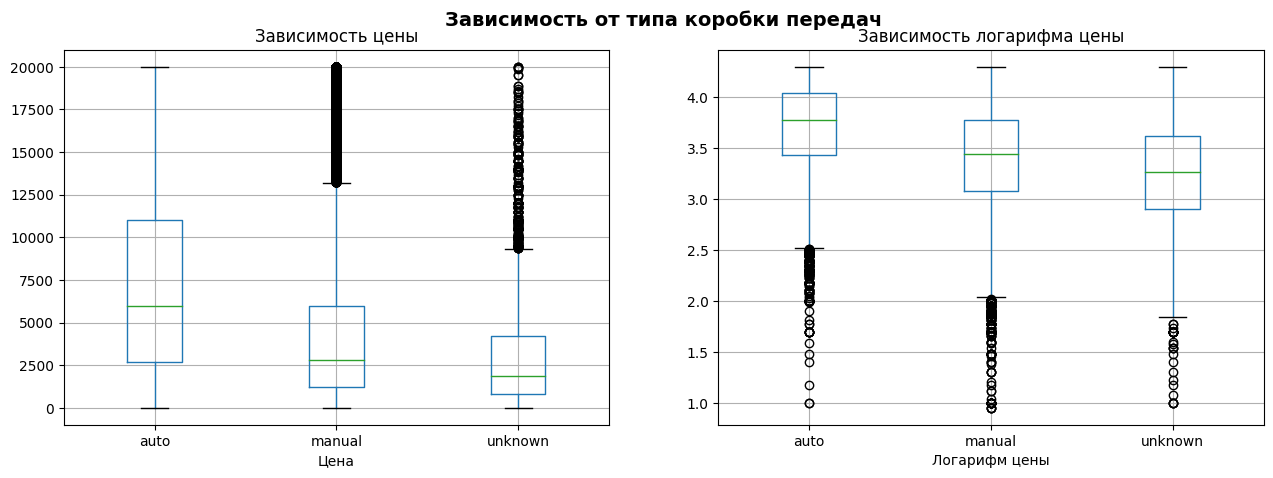

In [93]:
#Цена В зависимости от  типа коробки передач
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))

df.boxplot(column = ['price'], by='gearbox', ax = axes[0]);
df.boxplot(column = ['log_price'], by='gearbox', ax = axes[1]);

fig.suptitle('Зависимость от типа коробки передач', fontsize=14, fontweight='bold');
axes[0].set(title = "Зависимость цены", xlabel = "Цена");
axes[1].set(title = "Зависимость логарифма цены", xlabel = "Логарифм цены");

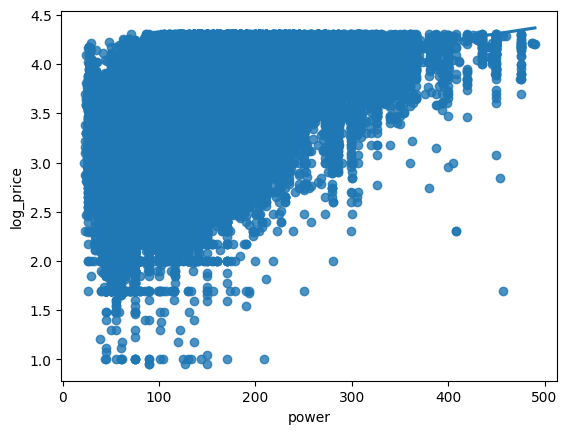

In [94]:
#Пробуем апроксимировать зависимость с помощью непараметрической locally weighted linear regression
sns.regplot(data = df, x = 'power', y = 'log_price', lowess = True);

Еще разубеждаемся, что регрессионные модели нам не подходят.Посмотрим на зависимости между ценой и номинативными переменными.

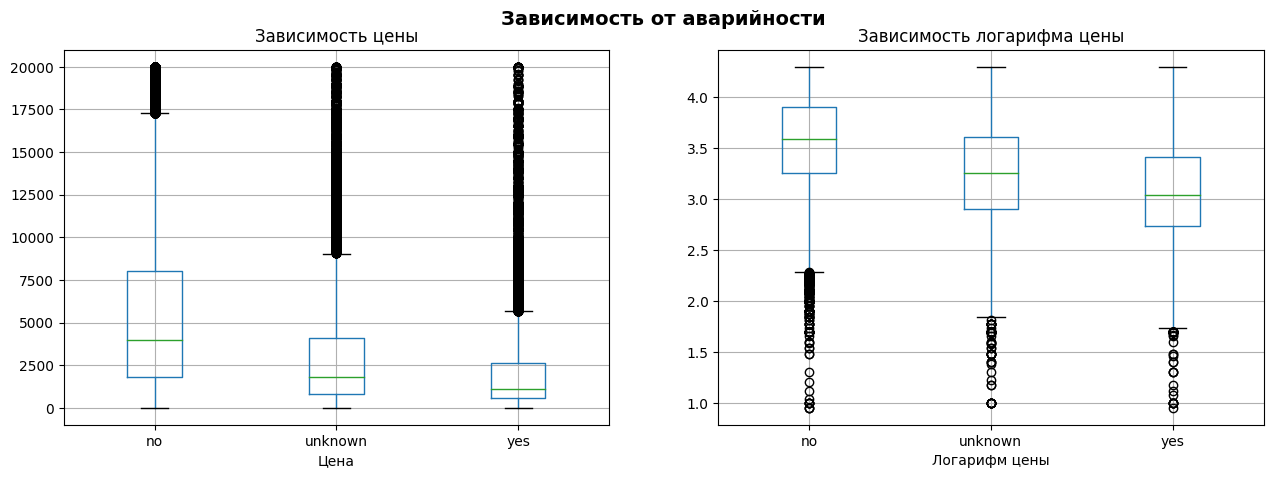

In [95]:
#Цена В зависимости от  наличия аварий
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
df.boxplot(column = ['price'], by='repaired', ax = axes[0]);
df.boxplot(column = ['log_price'], by='repaired', ax = axes[1]);

fig.suptitle('Зависимость от аварийности', fontsize=14, fontweight='bold');
axes[0].set(title = "Зависимость цены", xlabel = "Цена");
axes[1].set(title = "Зависимость логарифма цены", xlabel = "Логарифм цены");

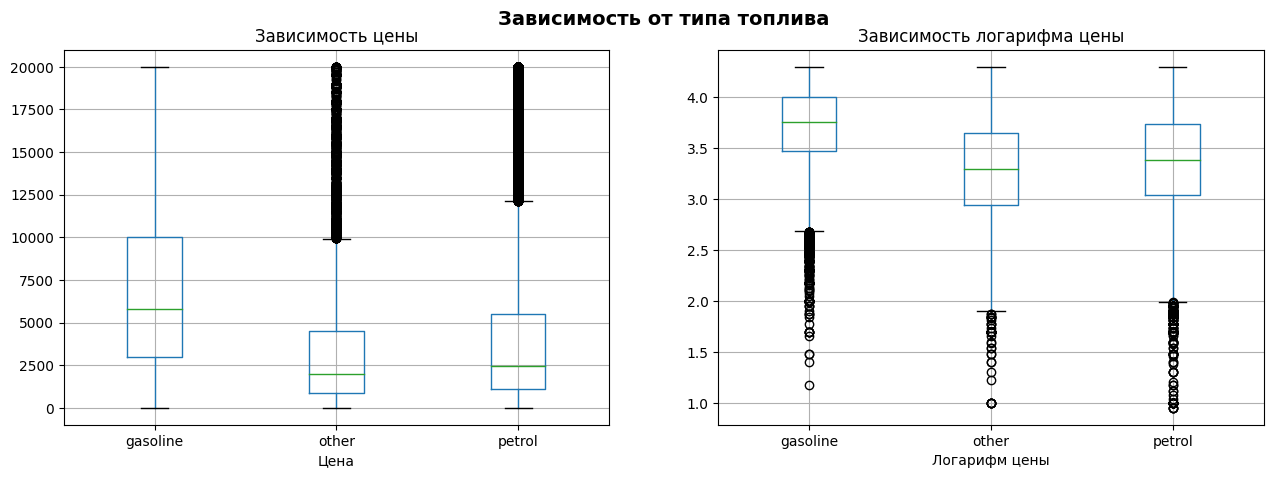

In [96]:
#Цена В зависимости от типа топлива
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
df.boxplot(column = ['price'], by='fuel_type', ax = axes[0]);
df.boxplot(column = ['log_price'], by='fuel_type', ax = axes[1]);

fig.suptitle('Зависимость от типа топлива', fontsize=14, fontweight='bold');
axes[0].set(title = "Зависимость цены", xlabel = "Цена");
axes[1].set(title = "Зависимость логарифма цены", xlabel = "Логарифм цены");

Таким образом мы можем ожидать, что при прочих равных цена будет выше:
- у авто с автоматической коробкой передач
- у авто, относительно которого известно, что оно не попадало в аварии
- у авто на газовом топливе

Попробуем оценить с помощью дисперсионного анализа (anova) есть ли статистически значимая связь между ценой, мощностью двигателя, годомрегистрации и пробегом 

In [97]:
pois = sf.glm('price ~ power + reg_year + km', \
              family = sm.families.Poisson(), data = df).fit()
pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:               284324
Model:                            GLM   Df Residuals:                   284320
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7216e+08
Date:                Sat, 13 May 2023   Deviance:                   3.4152e+08
Time:                        13:36:31   Pearson chi2:                 5.20e+08
No. Iterations:                    11   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -196.5353      0.014  -1.43e+04      0.000    -196.562    -196.508
power          0.0067   4.12e-07   1.62e+04      0.000       0.007       0.007
reg_year       0.1020   6.85e-06   1.49e+04      0.000       0.102       0.102
km         -3.314e-06   7.85e-10  -4222.168      0.000   -3.32e-06   -3.31e-06
==============================================================================
"""

К сожалению ожидаемых статистически значимых взаимосвязей между ценой и количественными признаками дисперсионный анализ не выявил. Возможно потому, что наше распределение сильно отличается от Пуассоновского. 

### Проверка на мультиколлинеарность

In [98]:
numeric = ['price', 'power', 'km']

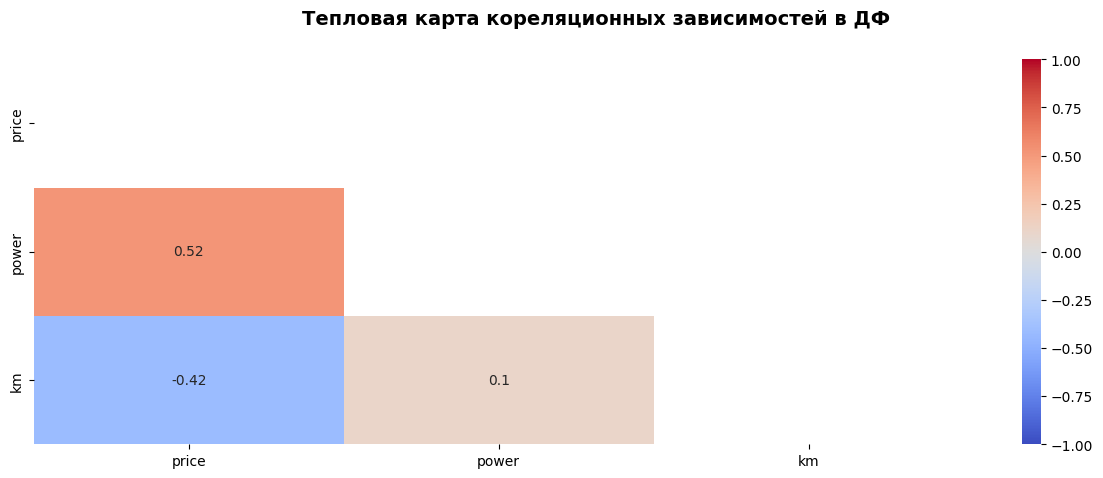

In [99]:
#Функция для плотностей вероятности по шагам для всех видов металла
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
# Заголовок фигуры
fig.suptitle\
('Тепловая карта кореляционных зависимостей в ДФ', fontsize=14, fontweight='bold');
#Тепловая карта корреляции 
corr_mat = np.triu(df[numeric].corr())
sns.heatmap(df[numeric].corr(),\
            vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = corr_mat);

Судя по тепловой карте в рассматриваемой выборке имеется:

- положительная коррялиционная зависимость между ценой и мощностью двигателя;
- слабая отрицательная коррялиционная зависимость между ценой и пробегом;

Корреляция между независимыми переменными (мультиколлинераность) не выявлена.

### Подготовка данных для обучения моделей

#### Удаление лишних категориальных столбцов (тех, которые уже закодированы) 

In [100]:
df = df.drop(['group_brand', 'group_model', 'vehicle_type', 'brand', 'model'], axis = 1)

### Назначаем для всех колонок числовой тип

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284324 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        284324 non-null  int64  
 1   reg_year     284324 non-null  int64  
 2   gearbox      284324 non-null  object 
 3   power        284324 non-null  int64  
 4   km           284324 non-null  int64  
 5   reg_month    284324 non-null  int64  
 6   fuel_type    284324 non-null  object 
 7   repaired     284324 non-null  object 
 8   postal_code  284324 non-null  int64  
 9   vehicle_kat  284324 non-null  int64  
 10  brand_kat    284324 non-null  int64  
 11  model_kat    284324 non-null  int64  
 12  log_price    284324 non-null  float64
dtypes: float64(1), int64(9), object(3)
memory usage: 30.4+ MB


#### Кодирование методом one-hot-encoder

Применять OHE нецелесообразно, так как это черезмерно увеличивает масштабность данных 

#### Разделение на обучающую и тестовую выборки

In [102]:
target = df.price
target_log = df.log_price
features = df.drop(['price', 'log_price'],axis = 1)

In [103]:
#Массивы без лог-преобразования
test_t, train_t, test_f, train_f = train_test_split(target, features, test_size = 0.25, random_state = RS)

#Массивы с лог-преобразованием
test_t_log, train_t_log, test_f, train_f = train_test_split(target_log, features, test_size = 0.25, random_state = RS)

In [104]:
train_f.columns

Index(['reg_year', 'gearbox', 'power', 'km', 'reg_month', 'fuel_type',
       'repaired', 'postal_code', 'vehicle_kat', 'brand_kat', 'model_kat'],
      dtype='object')

In [105]:
df.gearbox.unique()

array(['manual', 'auto', 'unknown'], dtype=object)

#### Кодирование методом OrdinalEncoder

In [106]:
encoder = OrdinalEncoder()

#Кодирование тренировочной выборки
train_f.loc[:,['gearbox', 'fuel_type', 'repaired']] =\
encoder.fit_transform(train_f[['gearbox', 'fuel_type', 'repaired']])

#Кодирование тестовой выборки
test_f.loc[:,['gearbox', 'fuel_type', 'repaired']] =\
encoder.transform(test_f[['gearbox', 'fuel_type', 'repaired']])

<ipython-input-106-fae63ef5a54c>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_f.loc[:,['gearbox', 'fuel_type', 'repaired']] =\
<ipython-input-106-fae63ef5a54c>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_f.loc[:,['gearbox', 'fuel_type', 'repaired']] =\


In [107]:
train_f.head()

,reg_year,gearbox,power,km,reg_month,fuel_type,repaired,postal_code,vehicle_kat,brand_kat,model_kat
247566,1999,1.0,193,150000,0,2.0,0.0,51149,5,26,144
91152,2014,1.0,125,20000,3,2.0,0.0,93138,4,7,52
30526,1999,1.0,75,150000,3,2.0,0.0,63820,3,19,39
35877,2003,1.0,54,125000,2,2.0,0.0,34466,1,3,5
67820,2001,0.0,163,150000,0,1.0,1.0,28790,4,26,117


#### Альтернативный вариант - подготовка данных для использования LightGBM без кодирования 

In [108]:
#Подготавливаем выборки
train_f_cat_gbm = train_f 
test_f_cat_gbm = test_f 

#Устанавливаем требуемый тип для номинативных столбцов
columns_with_category = ['gearbox', 'repaired', 'fuel_type']
for feature in columns_with_category:
    train_f_cat_gbm[feature] = pd.Series(train_f_cat_gbm[feature], dtype="category")
    test_f_cat_gbm[feature] = pd.Series(test_f_cat_gbm[feature], dtype="category")

#### Масштабирование данных

In [109]:
numeric = ['power', 'km', 'reg_year', 'reg_month']

Так как представленные в ДФ количественные переменные имеют НЕнормальное распределение, предпочтительнее вместо StandardScaler использовать MinMaxScaler

In [110]:
#Масштабирование данных методом MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_f)

mm_train_f = mm_scaler.transform(train_f)
mm_test_f = mm_scaler.transform(test_f)

#Масштабирование выборки для gbm с собственным кодированием
mm_train_f_cat_gbm = mm_scaler.transform(train_f_cat_gbm)
mm_test_f_cat_gbm = mm_scaler.transform(test_f_cat_gbm)


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что scaler обучен только на трейне
</div>


### Определяем baseline моделей

In [111]:
#Словарь, который будет аккумулироваь результаты
results = {'step': [], 'model_name': [], 'RMSE': [], 'fit_time': [], 'predict_time': [],
          'feature_importances': []}


В качестве начального бейслайна возьмем значения RMSE для моделей с гиперпараметрами по-умолчанию

#### Определяем baseline линейной модели 

Так как на этапе EDA было определено, что расспределение целевого признака не позволяет применить к ДФ модели линейной регрессии.
Вместе с тем также была выявлена близкая к линейной взаимосвязь между пробегом, мощностью двигателя и ценой и полиномиальная зависимость между годом регистрации и ценой можно попробовать выполнить предсказания с помощью моделей линейной регрессии на логарифме целевого признака. Для облегчения подбора гиперпараметров и снижения рисков завышения сложности модели используем модель с реализованной регуляризацией: ElasticNet.

In [112]:
#Создание объекта модели
base_el_model = ElasticNet(random_state = RS)

#Обучение модели
start = time.time()
base_el_model.fit(mm_train_f, train_t_log)
end = time.time()
fit_el_time = (end - start)

#Предсказание
start = time.time()
el_predict_log = base_el_model.predict(mm_train_f)
el_predict = 10**(el_predict_log)
end = time.time()
pr_el_time = (end - start)

#Расчет метрик
el_rmse = (mean_squared_error(train_t, el_predict))**0.5

print(f' RMSE: {el_rmse}, fit time: {fit_el_time} s, predict time: {pr_el_time} s')

#Заполняем Словарь с результатами
rez = {'step': 'baseline', 'model_name': 'ElasticNet', 
       'RMSE': el_rmse, 'fit_time': fit_el_time, 'predict_time': pr_el_time}

results = write_results(results, rez)

 RMSE: 4981.492149580585, fit time: 0.01234292984008789 s, predict time: 0.0042951107025146484 s


Полученная метрика RMSE в два раза выше оговоренной в ТЗ. Попробуем посмотреть на другие модели.

#### Определяем baseline деревянной модели

In [113]:
start = time.time()
base_dt_model = DecisionTreeRegressor(random_state = RS)

#Обучение модели
start = time.time()
base_dt_model.fit(mm_train_f, train_t)
end = time.time()
fit_dt_time = (end - start)

#Предсказание
start = time.time()
dt_predict = base_dt_model.predict(mm_train_f)
end = time.time()
pr_dt_time = (end - start)

#Расчет метрик
dt_rmse = (mean_squared_error(train_t, dt_predict))**0.5

print(f' RMSE: {dt_rmse}, fit time: {fit_dt_time} s, predict time: {pr_dt_time} s') 

#Заполняем Словарь с результатами
rez = {'step': 'baseline', 'model_name': 'DecisionTreeRegressor', 
       'RMSE': dt_rmse, 'fit_time': fit_dt_time, 'predict_time': pr_dt_time,
       'feature_importances': base_dt_model.feature_importances_}

results = write_results(results, rez)

 RMSE: 49.14484506139283, fit time: 0.5840446949005127 s, predict time: 0.03164410591125488 s


#### Определяем baseline модели LightGBM

In [114]:
start = time.time()
base_gbm_model = LGBMRegressor()

#Обучение модели
start = time.time()
base_gbm_model.fit(mm_train_f, train_t)
end = time.time()
fit_gbm_time = (end - start)

#Предсказание
start = time.time()
gbm_predict = base_gbm_model.predict(mm_train_f)
end = time.time()
pr_gbm_time = (end - start)

#Расчет метрик
gbm_rmse = (mean_squared_error(train_t, gbm_predict))**0.5

print(f' RMSE: {gbm_rmse}, fit time: {fit_gbm_time} s, predict time: {pr_gbm_time} s') 

#Заполняем Словарь с результатами
rez = {'step': 'baseline', 'model_name': 'LGBMRegressor (OrdinalEncoder)', 
       'RMSE': gbm_rmse, 'fit_time': fit_gbm_time, 'predict_time': pr_gbm_time,
       'feature_importances': base_gbm_model.feature_importances_}

results = write_results(results, rez)

 RMSE: 1528.4876227339382, fit time: 0.7135927677154541 s, predict time: 0.35610103607177734 s


#### Определяем baseline GAM модели на основе сплайнов 

In [115]:
#Признаки
train_f_gam = train_f

train_t_gam = train_t + 0.001

#Обучение модели
start = time.time()
base_gam_model = GAM().fit(train_f_gam, train_t_gam)
end = time.time()
fit_gam_time = (end - start)

#Предсказание
start = time.time()
gam_predict = base_gam_model.predict(train_f_gam)
end = time.time()
pr_gam_time = (end - start)

gam_rmse = (mean_squared_error(train_t, gam_predict))**0.5

print(f' RMSE: {gam_rmse}, fit time: {fit_gbm_time} s, predict time: {pr_gam_time} s') 

#Заполняем Словарь с результатами
rez = {'step': 'baseline', 'model_name': 'GAM', 
       'RMSE': gam_rmse, 'fit_time': fit_gam_time, 'predict_time': pr_gam_time,
       }

results = write_results(results, rez)

 RMSE: 2047.1992410214461, fit time: 0.7135927677154541 s, predict time: 1.3350648880004883 s


## Подбор оптимальных гиперпараметров

Для того,чтобы избежать переобучения подбор гиперпараметров в простых моделях будет осуществлять с помощью повторной стратифицированной k-кратной кросс-валидации с тремя повторами и k, равным 10.

#### Подбор гиперпараметров для модели линейной регрессии

In [116]:
el_model = ElasticNet()
el_params = {'max_iter':[500, 1000], 'alpha':[0.5, 1], 'selection': ('cyclic', 'random')}

(el_best_model, times, RMSE) = search_best_params(mm_train_f, train_t, el_model, el_params, RS)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'ElasticNet', 
       'RMSE': RMSE, 
       'fit_time': np.mean(times[1]), 'predict_time': np.mean(times[2]), 'grid_time': np.mean(times[0]), 
        }

results = write_results(results, rez)

START fiting
Inital fiting finished. Fit time: 2.4154610633850098 s
START cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.3s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   9 task

Grid searching finished.     Grid time: 8.589324951171875 s,    Mean fit time: 0.055498749017715454 s    Mean predict time: 0.002883732318878174 s
mean RMSE: 3787.1628394187064, std RMSE: 268.9260088709958
best params: {'alpha': 0.5, 'max_iter': 1000, 'selection': 'random'}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.5s finished


На этапе подбора гиперпараметров не удалось подобрать гиперпараметры так, чтобы достигнуть требуемой величины метрики качества даже на обучающей выборке. Поэтому в дальнейшем работать с моделью линейной регрессии нецелесообразно 

#### Подбор гиперпараметров для модели дерева решений

In [117]:
dt_model = DecisionTreeRegressor()
dt_params = {'splitter': ('best', 'random'), 'max_depth': [10, 50, 100], 
             'min_samples_split': [2, 4, 6], 'min_samples_leaf': [2, 4, 6]}

(dt_best_model, times, RMSE) = search_best_params(mm_train_f, train_t, dt_model, dt_params, RS)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'DecisionTreeRegressor', 
       'RMSE': RMSE, 
       'fit_time': np.mean(times[1]), 'predict_time': np.mean(times[2]), 'grid_time': np.mean(times[0]),
       'feature_importances': dt_best_model.best_estimator_.feature_importances_}

results = write_results(results, rez)

START fiting
Inital fiting finished. Fit time: 59.59955072402954 s
START cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   59.5s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   9 task

Grid searching finished.     Grid time: 353.7220425605774 s,    Mean fit time: 0.2144410566047386 s    Mean predict time: 0.004748285258257831 s
mean RMSE: 1902.992188768182, std RMSE: 267.63273531190833
best params: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 6, 'splitter': 'best'}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min finished


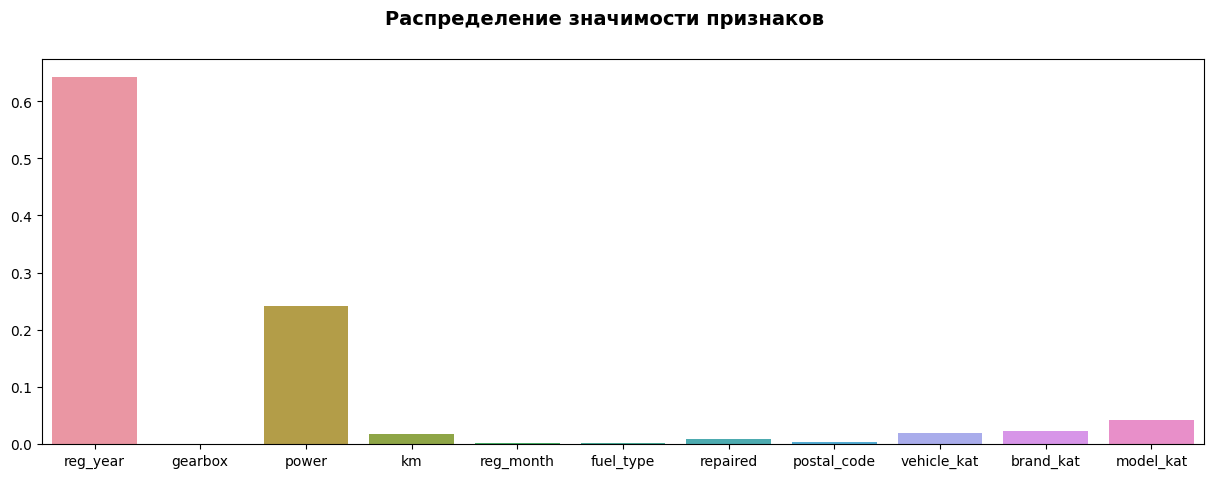

In [118]:
x= ['reg_year', 'gearbox', 'power', 'km', 'reg_month', 'fuel_type',
       'repaired', 'postal_code', 'vehicle_kat', 'brand_kat', 'model_kat']
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение значимости признаков', fontsize=14, fontweight='bold');
sns.barplot(y = dt_best_model.best_estimator_.feature_importances_, x = x);

#### Подбор гиперпараметров для модели LightGBM (c кодированием данных методом OrdinalEncoder)

In [119]:
gbm_model = LGBMRegressor()
gbm_params = {'n_estimators': [5, 10], 'max_depth': [5, 10], 
             'learning_rate': [0.2]}

(gbm_best_model, times, RMSE) = search_best_params(mm_train_f, train_t, gbm_model, gbm_params, RS)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'LGBMRegressor (OrdinalEncoder)', 
       'RMSE': RMSE, 
       'fit_time': np.mean(times[1]), 'predict_time': np.mean(times[2]), 'grid_time': np.mean(times[0]),
       'feature_importances': gbm_best_model.best_estimator_.feature_importances_}

results = write_results(results, rez)

START fiting
Inital fiting finished. Fit time: 2.656514883041382 s
START cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.5s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   9 task

Grid searching finished.     Grid time: 25.92892837524414 s,    Mean fit time: 0.11698025465011597 s    Mean predict time: 0.00706634521484375 s
mean RMSE: 1920.5915861856531, std RMSE: 189.0335986769408
best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   25.8s finished


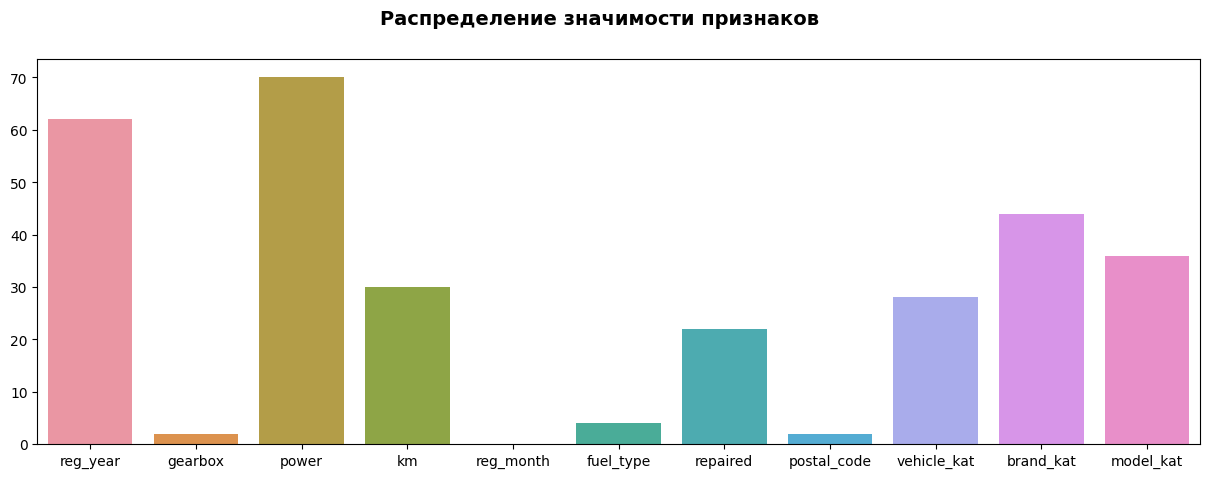

In [120]:
x= ['reg_year', 'gearbox', 'power', 'km', 'reg_month', 'fuel_type',
       'repaired', 'postal_code', 'vehicle_kat', 'brand_kat', 'model_kat']
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение значимости признаков', fontsize=14, fontweight='bold');
sns.barplot(y =  gbm_best_model.best_estimator_.feature_importances_, x = x);

#### Подбор гиперпараметров для модели LightGBM (без кодирования данных)

In [121]:
gbm_model = LGBMRegressor()
gbm_params = {'n_estimators': [5, 10], 'max_depth': [5, 10], 
             'learning_rate': [0.2]}

(gbm_cat_best_model_cat, times, RMSE) = search_best_params(mm_train_f_cat_gbm, train_t, gbm_model, gbm_params, RS)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'LGBMRegressor (no encoder)', 
       'RMSE': RMSE, 
       'fit_time': np.mean(times[1]), 'predict_time': np.mean(times[2]), 'grid_time': np.mean(times[0]),
       'feature_importances': gbm_cat_best_model_cat.best_estimator_.feature_importances_}

results = write_results(results, rez)

START fiting
Inital fiting finished. Fit time: 2.6461293697357178 s
START cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   9 task

Grid searching finished.     Grid time: 22.49385976791382 s,    Mean fit time: 0.11713839769363404 s    Mean predict time: 0.006528103351593017 s
mean RMSE: 1920.5915861856531, std RMSE: 189.0335986769408
best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   22.4s finished


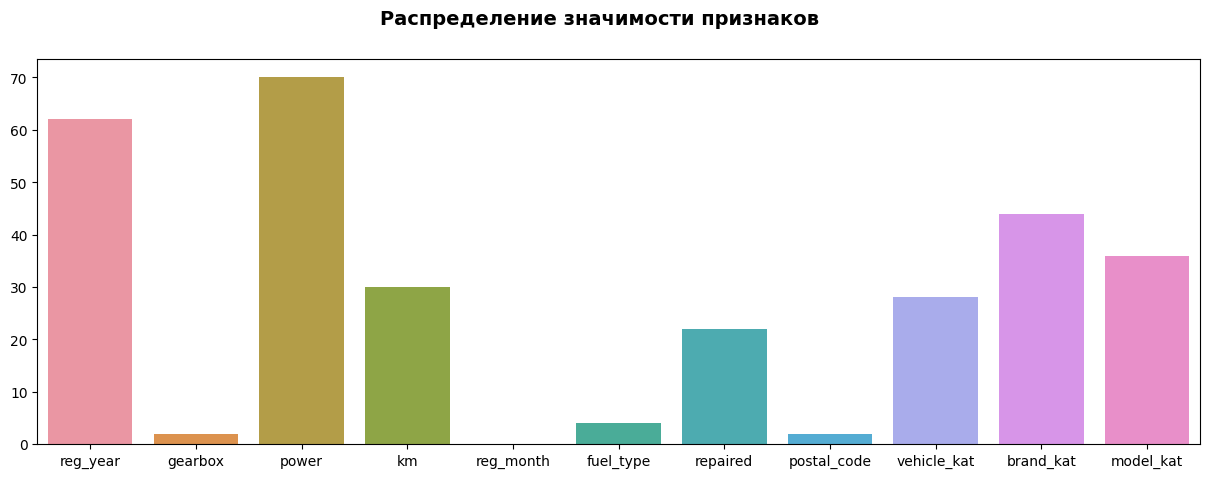

In [122]:
x= ['reg_year', 'gearbox', 'power', 'km', 'reg_month', 'fuel_type',
       'repaired', 'postal_code', 'vehicle_kat', 'brand_kat', 'model_kat']
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение значимости признаков', fontsize=14, fontweight='bold');
sns.barplot(y =  gbm_cat_best_model_cat.best_estimator_.feature_importances_, x = x);

#### Подбор гиперпараметров для GAM модели на основе сплайнов 

In [123]:
#Генерируем случайные комбинации для коэффициентов сплайнов
spline = np.arange(4, 6, 1)
splines = [spline]*4

In [124]:
#Подбор параметров
start = time.time()
gam_model = GAM(s(0)+s(1)+s(2)+s(3)).gridsearch(train_f_gam.values, train_t_gam, n_splines = splines)
end = time.time()
grid_gam_time = (end - start)

#Обучение модели
start = time.time()
gam_model.fit(train_f_gam.values, train_t_gam)
end = time.time()
fit_gam_time = (end - start)

#Предсказание
start = time.time()
train_gam_predict = gam_model.predict(train_f_gam)
end = time.time()
pr_gam_time = (end - start)

gam_times = (grid_gam_time, fit_gam_time, pr_gam_time)
train_gam_rmse = (mean_squared_error(train_t, train_gam_predict))**0.5

print("Grid searching finished. \
    Grid time: {grid_gam_time} s,\
    Mean fit time: {fit_gam_time} s\
    Mean predict time: {pr_gam_time} s")
print(train_gam_rmse**0.5) 

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'GAM', 
       'RMSE': train_gam_rmse, 'fit_time': fit_gam_time, 
       'predict_time': pr_gam_time, 'grid_time': grid_gam_time}

results = write_results(results, rez)


100% (16 of 16) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


Grid searching finished.     Grid time: {grid_gam_time} s,    Mean fit time: {fit_gam_time} s    Mean predict time: {pr_gam_time} s
48.61650049863945


## Анализ характеристик моделей

In [125]:
df_results = pd.DataFrame(results)

In [126]:
df_results

,step,model_name,RMSE,fit_time,predict_time,feature_importances
0,baseline,ElasticNet,4981.492150,0.012343,0.004295,None
1,baseline,DecisionTreeRegressor,49.144845,0.584045,0.031644,"[0.5632057763317628, 0.004924205332249997, 0.2..."
2,baseline,LGBMRegressor (OrdinalEncoder),1528.487623,0.713593,0.356101,"[564, 58, 607, 221, 66, 71, 114, 197, 237, 417..."
3,baseline,GAM,2047.199241,8.720255,1.335065,None
4,train,ElasticNet,3787.162839,0.055499,0.002884,None
5,train,DecisionTreeRegressor,1902.992189,0.214441,0.004748,"[0.6414165184443437, 0.0006368471639259785, 0...."
6,train,LGBMRegressor (OrdinalEncoder),1920.591586,0.116980,0.007066,"[62, 2, 70, 30, 0, 4, 22, 2, 28, 44, 36]"
7,train,LGBMRegressor (no encoder),1920.591586,0.117138,0.006528,"[62, 2, 70, 30, 0, 4, 22, 2, 28, 44, 36]"
8,train,GAM,2363.564121,0.355375,0.177568,None


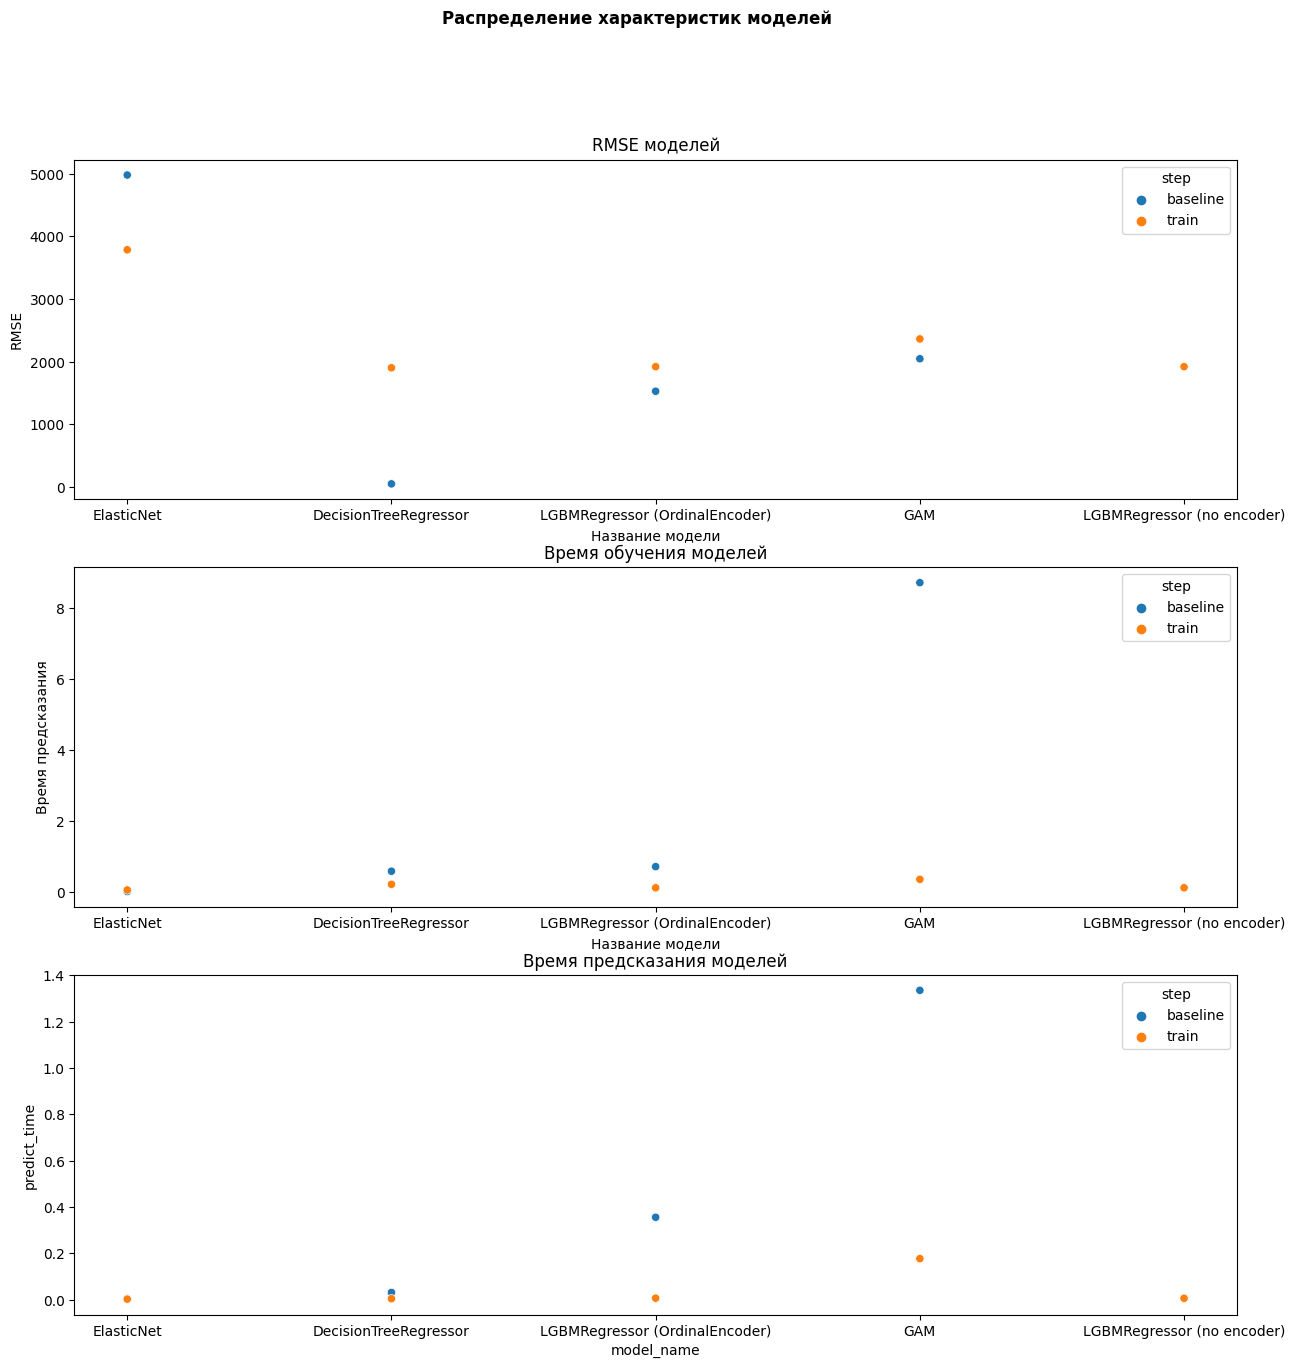

In [127]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharey = False, figsize = (15, 15))
fig.suptitle('Распределение характеристик моделей', fontsize=12, fontweight='bold');
sns.scatterplot(y =  df_results.RMSE, x = df_results.model_name, ax = axes[0], hue = df_results.step);
sns.scatterplot(y =  df_results.fit_time, x = df_results.model_name, ax = axes[1], hue = df_results.step);
sns.scatterplot(y =  df_results.predict_time, x = df_results.model_name, ax = axes[2], hue = df_results.step);

axes[0].set_xlabel("Название модели");
axes[0].set_ylabel("RMSE");
axes[0].set(title = "RMSE моделей");

axes[1].set_xlabel("Название модели");
axes[1].set_ylabel("Время обучения"); 
axes[1].set(title = "Время обучения моделей");

axes[1].set_xlabel("Название модели");
axes[1].set_ylabel("Время предсказания");
axes[2].set(title = "Время предсказания моделей");

На основании оценки результатов подбора гиперпараметров моделей методом кросс-валидации следут отметить, что:
1. DecisionTreeRegressor переобучилась без кросс-валидации, остальные модели после подбора гиперпараметров показали улечшенные по сравнению с базовыми метррики
2. Лучшего RMSE достигла модель DecisionTreeRegressor: 1903.090604, чуть хуже результаты у LightGBM  
3. Из моделей, с приемлимыми RMSE наименьшее время обучения у DecisionTreeRegressor: 0.149921, у LightGBM - больше: 0.323678
4. Из моделей, с приемлимыми RMSE наименьшее время предсказания у DecisionTreeRegressor: 0.003741, у LightGBM - больше: 0.011179
5. Показатели качества у LightGBM с встроенным кодированием немного лучше, чем с кодированием методом OrdinalEncoder

ВЫВОД:
Лучшая из рассмотренных модель - DecisionTreeRegressor. Ее проверим на тестовой выборке

## Проверка моделей на тестовых данных

#### Модель дерева решений

In [128]:
start = time.time()
base_dt_model = dt_best_model.best_estimator_

#Обучение модели
start = time.time()
base_dt_model.fit(mm_train_f, train_t)
end = time.time()
fit_dt_time = (end - start)

#Предсказание
start = time.time()
dt_predict = base_dt_model.predict(mm_test_f)
end = time.time()
pr_dt_time = (end - start)

#Расчет метрик
dt_rmse = (mean_squared_error(test_t, dt_predict))**0.5

print(f' RMSE: {dt_rmse}, fit time: {fit_dt_time} s, predict time: {pr_dt_time} s') 

#Заполняем Словарь с результатами
rez = {'step': 'test', 'model_name': 'DecisionTreeRegressor', 
       'RMSE': dt_rmse, 'fit_time': fit_dt_time, 'predict_time': pr_dt_time,
       'feature_importances': base_dt_model.feature_importances_}

results = write_results(results, rez)

 RMSE: 1876.6800072068174, fit time: 0.26287412643432617 s, predict time: 0.024669170379638672 s


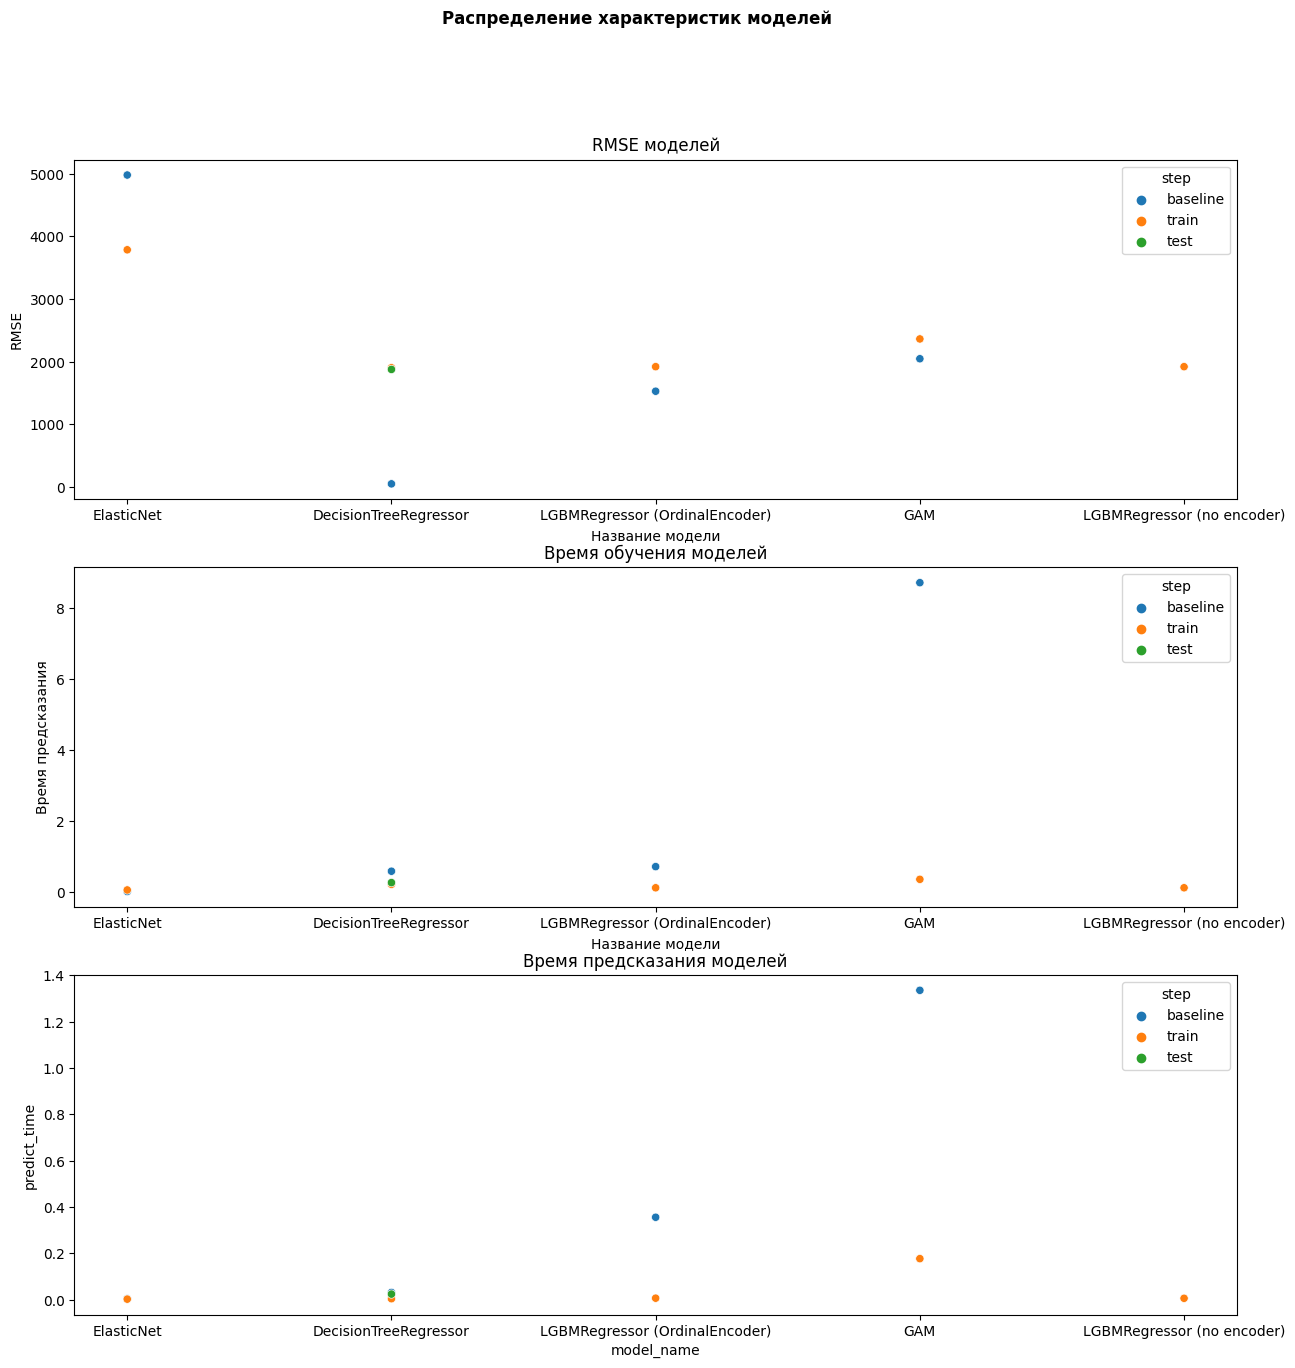

In [129]:
df_results = pd.DataFrame(results)
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharey = False, figsize = (15, 15))
fig.suptitle('Распределение характеристик моделей', fontsize=12, fontweight='bold');
sns.scatterplot(y =  df_results.RMSE, x = df_results.model_name, ax = axes[0], hue = df_results.step);
sns.scatterplot(y =  df_results.fit_time, x = df_results.model_name, ax = axes[1], hue = df_results.step);
sns.scatterplot(y =  df_results.predict_time, x = df_results.model_name, ax = axes[2], hue = df_results.step);

axes[0].set_xlabel("Название модели");
axes[0].set_ylabel("RMSE");
axes[0].set(title = "RMSE моделей");

axes[1].set_xlabel("Название модели");
axes[1].set_ylabel("Время обучения"); 
axes[1].set(title = "Время обучения моделей");

axes[1].set_xlabel("Название модели");
axes[1].set_ylabel("Время предсказания");
axes[2].set(title = "Время предсказания моделей");

In [130]:
df_results

,step,model_name,RMSE,fit_time,predict_time,feature_importances
0,baseline,ElasticNet,4981.492150,0.012343,0.004295,None
1,baseline,DecisionTreeRegressor,49.144845,0.584045,0.031644,"[0.5632057763317628, 0.004924205332249997, 0.2..."
2,baseline,LGBMRegressor (OrdinalEncoder),1528.487623,0.713593,0.356101,"[564, 58, 607, 221, 66, 71, 114, 197, 237, 417..."
3,baseline,GAM,2047.199241,8.720255,1.335065,None
4,train,ElasticNet,3787.162839,0.055499,0.002884,None
5,train,DecisionTreeRegressor,1902.992189,0.214441,0.004748,"[0.6414165184443437, 0.0006368471639259785, 0...."
6,train,LGBMRegressor (OrdinalEncoder),1920.591586,0.116980,0.007066,"[62, 2, 70, 30, 0, 4, 22, 2, 28, 44, 36]"
7,train,LGBMRegressor (no encoder),1920.591586,0.117138,0.006528,"[62, 2, 70, 30, 0, 4, 22, 2, 28, 44, 36]"
8,train,GAM,2363.564121,0.355375,0.177568,None
9,test,DecisionTreeRegressor,1876.680007,0.262874,0.024669,"[0.6414165184443438, 0.0006368471639259788, 0...."


## Вывод по результатам проверки

По результатам сравнение результатов, установлено, что лучшей моделью является DecisionTreeRegressor:

    - RMSE на тестовой выборке 1876 
    - время обучения 0.21 (сек)
    - время предсказания 0.02 (сек)

## Выводы по результатам исследования

Целью исследования было подготовить модель расчета рыночной стоимости автомобиля пользователя для нового приложения заказчика. Модель должна была быть разработана на основании исследования исторических данных о ранее проданных автомобилях(предосталены в csv файле). Показателем качества модели требовалось принять RMSE, которая должна быть меньше 2500. 
При выборе модели важны:
- скорость обучения модели
- скорость предсказания модели
- точность предсказания

В процесе исследования:
1. Загружены и изучены исторические данные объявлений о продажах автомобилей 
2. Исследованы загруженные данные, определена их форма, типы, смысловая нагрузка
3. Выполнен EDA, включая:
     - проверку и переименование названий столбцов (приведение к стилю under_score)
     - проверку корректности назначенных типов данных (изменены столбецы с датами)
     - поиск полных и неявных дубликатов (4 полных дубликата удалено, неявные дубликаты не выявлены) 
     - поиск и заполнение пропусков (во всех номинативных переменных пропуски заполнены строкой unknown)
     - выявление аномальных значений, обнаружены:
         - некорректные значения в столбце год регистрации (reg_year), все строки с ними удалены;
         - записи о машинах, зарегистрированных в 2016 году, по которым отсутствует полная информация о цене и т.д., записи удалены;
         - записи из периода создания объявления, который не охвачен преставленной в ДФ информацией, строки с периодом создания с 2014 по 2015 год удалены из основного ДФ;
         - не "используемый" столбец numb_of_pic (во всех строчках  значение - 0), столбец исключен из ДФ;
         - странная "дискретность" величины пробега (целесообразно уточнить у заказчика)
         - странное очень весомое преобладание машин, с величиной пробега 15000 (целесообразно уточнить у заказчика)
         - большое количество неправдоподобно маленьких цен для автомобилей с пробегом 5000 км, записи исключены из ДФ;
         - крайне маленькие и крайне большие величины мощности двигателей, записи удалены из ДФ;
 
 - изучение характерных взаимосвязей, выявлена:
     - интересная циклическая связь между медианной ценой и датой создания/загрузки объявления
     - положительная, близкая к линейной связь между ценой и мощностью двигателя 
     - отрицательная, близкая к линейной связь между ценой и пробегом  
     - полиномиальная связь между ценой и годом регистрации автомобиля
  
  - снижение размерности номинативных данных:
     - малочисленные типы топлива объединены в группу другие
     - малочисленные типы брэндов авто стратифицированы в три группы по величине медианной цены для данного брэнда (другие с низкой ценой, другие с высокой ценой, другие со средней ценой)
     - модели авто, связанные с ранее стратифицированными брэндами, объединены в три группы(другие с низкой ценой, другие с высокой ценой, другие со средней ценой)
     - удалены неинформативные столбцы, затрудняющие обучение моделей (столбцы с датами, столбец с числом картинок)
   
   - поиск коррелированых столбцов (мультиколлиарность не выявлена)

4. Проведена подготовка данных к машинному обучению:
  - сформированы списки зависимых и независимых признаков для машинных моделей:
  - добавлен еще один целевой признак (логорифм цены)
  - выборка разделена на обучающую и тестовую;
  - проведено масштабирование количественных признаков методом preprocessing.MinMaxScaler
5. Подuотовлена функция, автоматизирующая перебор гиперпараметров на основе метода GridSearch и кросс-валидации.

6. Проведено машинное обучение:
     - созданы базовые (без перебора гиперпараметров) модели:
        - ElasticNet
        - DecisionTreeRegressor
        - LightGBM
        - GAM
     - подобраны гиперпараметры для указанных моделей, оценена метрика качества, полученная на обучающей выборке
     - лучшие модели с оптимальными гиперпараметрами проверены на тестовой выборке. 
     
     

7.По результатам сравнение результатов, установлено, что лучшей моделью является DecisionTreeRegressor:

    - RMSE на тестовой выборке 1876.754215 
    - время обучения 0.190479 (сек)
    - время предсказания 0.020762 (сек)


8. Для улучшения качества работы приложения рекомендуетя задать ограничения на ввод данных в формы объявлений:
    - по году регистрации: с 1980 - по настоящее время
    - по мощности двигателя: от 20 до 500 л.с.
    - уточнить природу дискретности пробега
    - уточнитьприроду появления околонулевых цен
    - уточнить природу пояпления большого кол-ва записей с пробегом, равным 15000
   

9. Как можно доработать проект:
- пропробовать применить другие методы обработки аномальных значений: устанавливать их равными 0 и создавать дополнительный столбец с меткой об "аномальности" обработанного значения;
- проиллюстрировать результативность предсказаний модели графиком Residuals plot (связь между остатками модели и предсказанными значениями),